# Gaussian Process Regression for Uncertainty Estimation of Performance Evaluations in Configurable Software Systems
# a proof of concept

## Domain
- How can input and output constraints alter performance of a SWS?
- configuration management and performance control as exogen variables of a SWS that are determined by the environmental configuration of a coupled STS  to __solve dynamic programming problems__ (like knappsack problem)
### Situation

- so called __non-functional configuration options__ ensure the proper alignment between hardware setup and desired performance 
- software is optimized for a variety of use-cases but as hardware is getting more complex there can be __hidden improvements__ => performance features

#### OR avoid worst case scenarios (performance bugs)
- a developers nightmare is __data loss without recovery__
- a maintainers nightmare is surpassing the tipping point into an __irreversible system crash__ (unstable fix points)
- a gamers nightmare: FPS drop during speedrun
### Summary


=> all of them can be thought as an __"escalation"__ (a somewhat new situation which isn't covered by a model) due to an __uncaught exception__ in a *compiled procedure* that has to be fixed / reassured in a superior layer of hierarchy (a *controlled environment*)

=> These exceptions can only be recognized if we have expectancy about next steps
- in case of error: Look at the state and compare each of them with the expected output of the transition function
- but all of them need a supervisor to trace back the error and determine a root cause


- In a __black box situation__ this is not possible though and we need monitoring and forecasting techniques to estimate if a future step has a clear tendency to deviate further than just a rare normal event (use epiphenomena to establish early warning systems) 
=> We want to call all of them a performance bug and a performance feature if an expected error gets corrected just in time AND the workaround improves the progression of the supersystem
- In terms of optimization we use the expectancy of an improvement to rescale the output to solve dynamic programming problems in a supersystem, like a knappsack problem in a content delivery network where the management wants to maximize throughput while limiting the energy footprint or tresholding buffersize.  


### Estimation Problems
- linear models average weights over samples -> no context control
- exponential complexity for stepwise linear regression
- associated risk with the impact of unexpected performance deviations need statistical parameters about a expectancy and for example different modes or moments of change
- find combinations of configurations options that have a clear tendency for each group extension
### Research Question
- reduce a exponentially complex computation problem to a NP-hard decision problem

## Data

In [113]:
from domain.env import DATA_SLICE_AMOUNT, USE_DUMMY_DATA
SWS = "x264_energy"
Y = "fixed-energy"
DATA_SLICE_AMOUNT = 1000
print(f"use '{SWS}' dataset with {DATA_SLICE_AMOUNT} samples and performance metric: {Y}")

use 'x264_energy' dataset with 1000 samples and performance metric: fixed-energy


In [114]:
import torch
import pandas as pd
from adapters.preprocessing import prepare_dataset, preprocessing
from application.init_pipeline import init_pipeline
from application.fully_bayesian_gp import get_data

def get_data(use_synthetic_data=False, inference="exact", sws="LLVM_energy", y_type="performance", training_size=1000):
    ds = prepare_dataset(dummy_data=use_synthetic_data, sws=sws, y_type=y_type)
    feature_names, X_train, X_test, y_train, y_test = preprocessing(ds, training_size=training_size)
    # slice X_test such that it has the same shape as X_train
    # TODO: this shouldn't be necessary
    if len(X_test) > len(X_train):
        X_test = X_test[:len(X_train)]
        y_test = y_test[:len(X_train)]

    # transform test data to tensor
    X_test = torch.tensor(X_test).float() if inference == "exact" else torch.tensor(X_test).double()
    y_test = torch.tensor(y_test).float() if inference == "exact" else torch.tensor(y_test).double()

    return (ds, X_train, X_test, y_train, y_test, feature_names)
ds, X_train, X_test, y_train, y_test, feature_names = get_data(use_synthetic_data=USE_DUMMY_DATA, sws=SWS, y_type=Y, training_size=DATA_SLICE_AMOUNT)
measurement_df = ds.get_measurement_df() if USE_DUMMY_DATA is False else pd.DataFrame(ds) # is a incidence matrix

Checking if x264_energy isn't already extracted
   root  no_asm  no_8x8dct  no_cabac  no_deblock  no_fast_pskip  no_mbtree  \
0     1       1          1         1           1              1          1   
1     1       1          1         1           1              1          1   
2     1       1          1         1           1              1          1   
3     1       1          1         1           1              1          1   
4     1       1          1         1           1              1          1   

   no_mixed_refs  no_weightb  rc_lookahead  ...  fixed-energy  \
0              1           1             1  ...        4.9908   
1              1           1             1  ...        5.1394   
2              1           1             1  ...        5.2798   
3              1           1             1  ...        5.0838   
4              1           1             1  ...        5.3794   

   benchmark-energy  benchmark-iperf  fixed-cpu  benchmark-cpu  \
0            1.2826       

## Prestudies

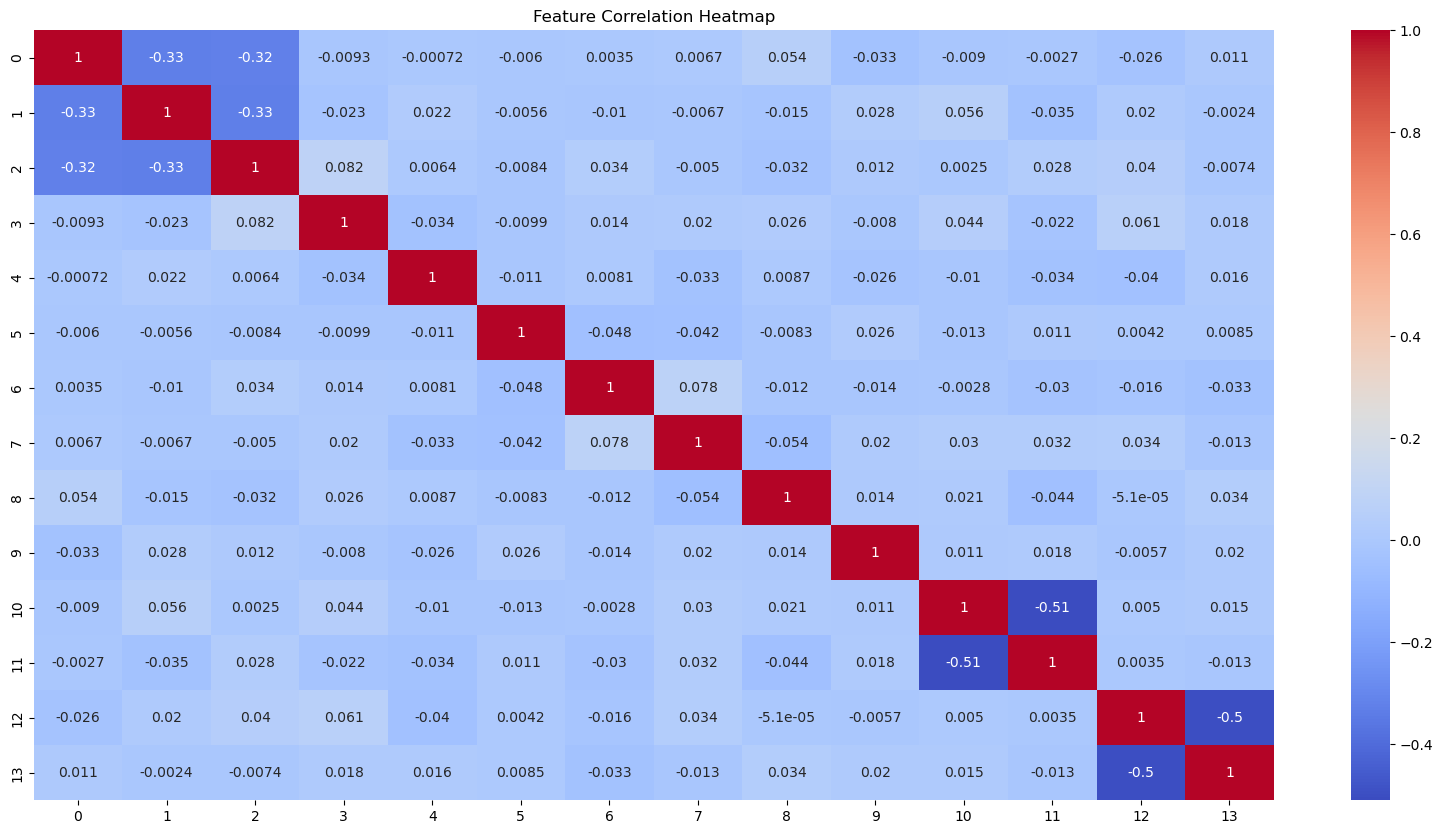

In [115]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

#corr_matrix = measurement_df.corr(method=pointbiserialr)
corr_matrix = np.corrcoef(X_train.T)
#corr_matrix = measurement_df.corr()

# Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Pair Plot
#sns.pairplot(measurement_df, hue="sink")
#plt.show()

In [6]:
mean_corr = measurement_df.corr().drop(columns=["y"], index=["y"]).abs().mean().mean()
mean_corr
target_corr = measurement_df.corr()["y"].abs()
selected_features = target_corr[target_corr > mean_corr].index.tolist()
selected_features.remove("y")
print("Selected Features:", selected_features)

Selected Features: ['adce', 'called_value_propagation', 'inline', 'instcombine', 'ipsccp', 'jump_threading', 'licm', 'pgo_memop_opt', 'sink', 'tailcallelim']


## L1 Regularization

ref_9              0.673252
core3              0.197645
no_mixed_refs      0.185713
core4              0.184809
core2              0.151957
ref_5              0.130191
no_mbtree          0.123886
no_8x8dct          0.089192
no_fast_pskip      0.068438
no_cabac           0.043695
no_weightb         0.017386
rc_lookahead_60    0.013804
no_deblock         0.011752
rc_lookahead_40    0.010222
dtype: float64


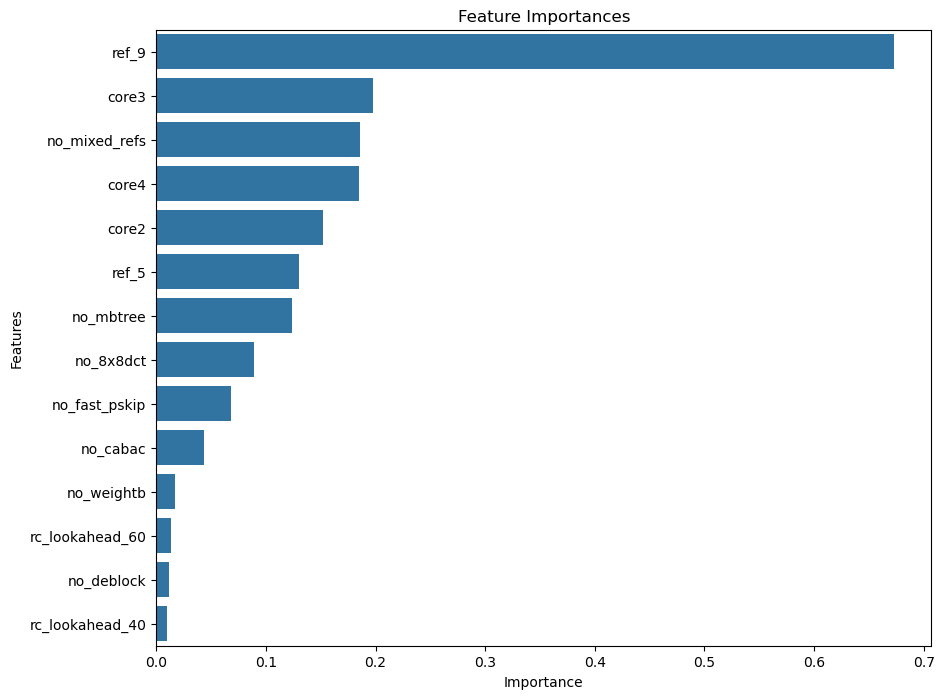

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

# Fit the model
#model = LassoCV(alphas=np.logspace(-2, 4, 1000))
model = RidgeCV()
model.fit(X_train, y_train)  # X is your features, y is your target variable

# Feature importances are the absolute values of the coefficients
feature_importances = pd.Series(abs(model.coef_), index=feature_names)

# Assuming 'feature_importances' is a dictionary or a Pandas Series 
# with feature names as keys and their importance (e.g., correlation coefficient) as values
# Example: feature_importances = {'feature1': 0.8, 'feature2': 0.75, ...}

# Convert to Pandas Series for easy plotting if it's not already
#feature_importances = measurement_df.corr()["y"].abs().sort_values(ascending=False)
feature_importances = pd.Series(feature_importances)

# Sort features based on importance
sorted_features = feature_importances.sort_values(ascending=False)
print(sorted_features)

# Create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_features.values, y=sorted_features.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Applying a L2 norm (euclidian) to the features, we see a nearly logarithmic distribution -> Zipf's Law
which is good for convex optimization
-> averaging out the weights over all samples makes the performance features untractable

-> only linear speedup

## Factor Analysis with PCA
-> 

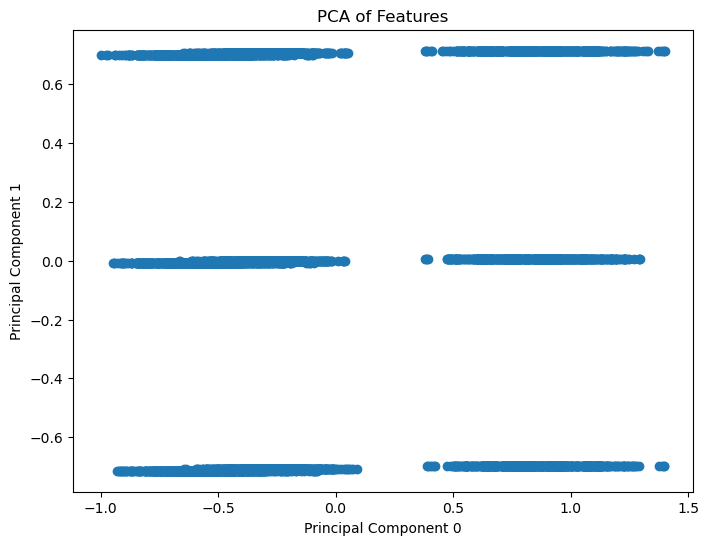

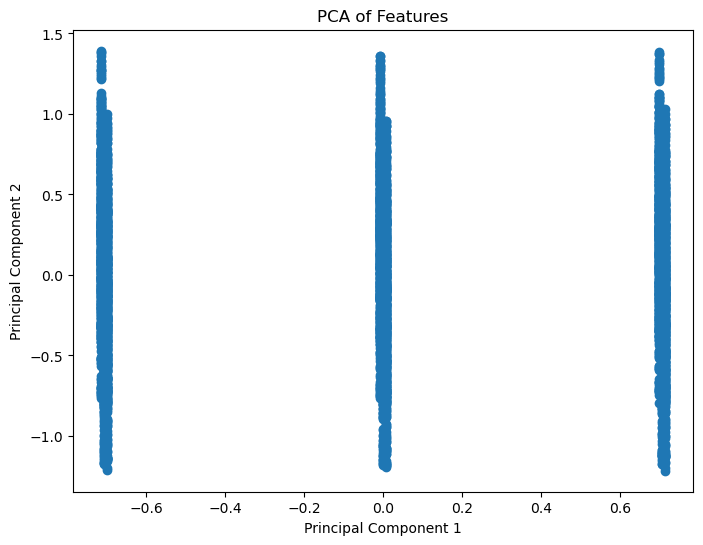

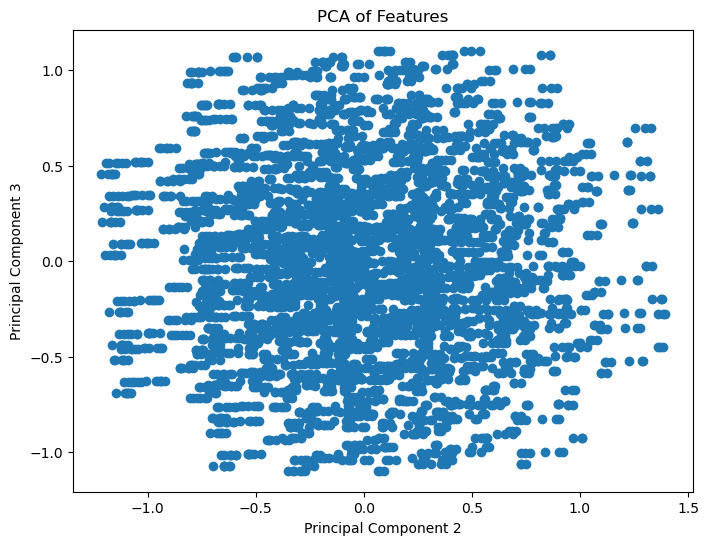

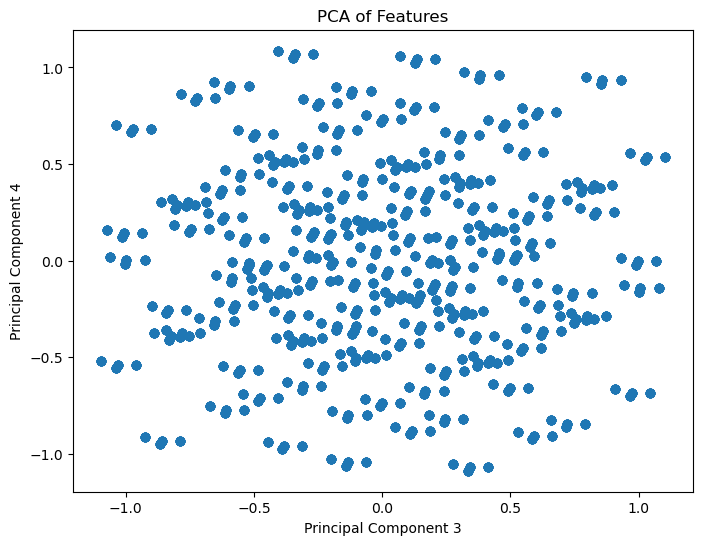

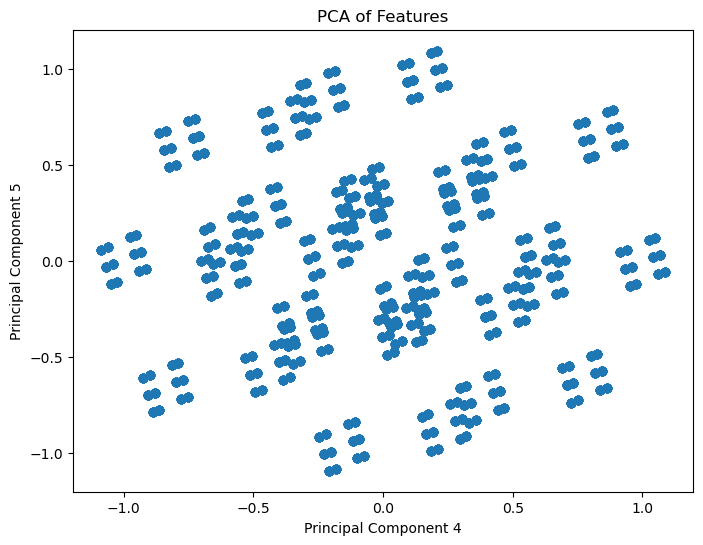

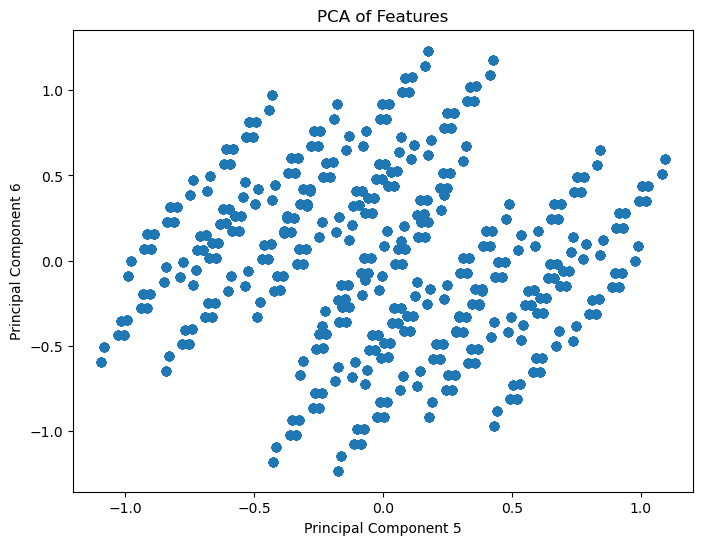

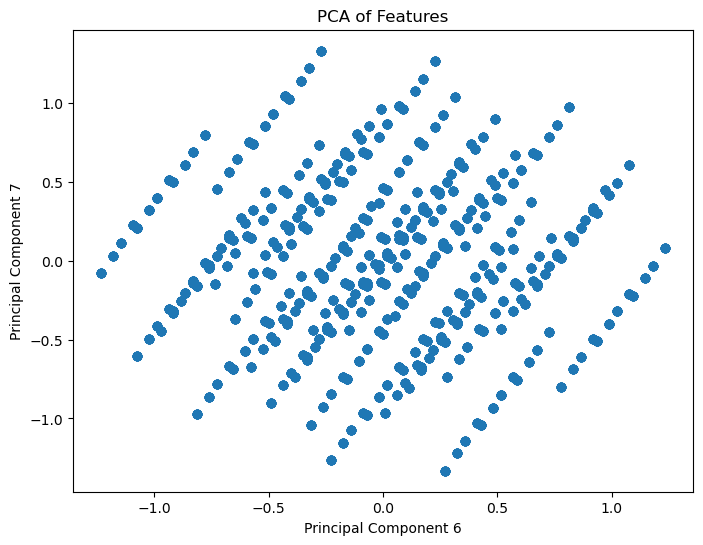

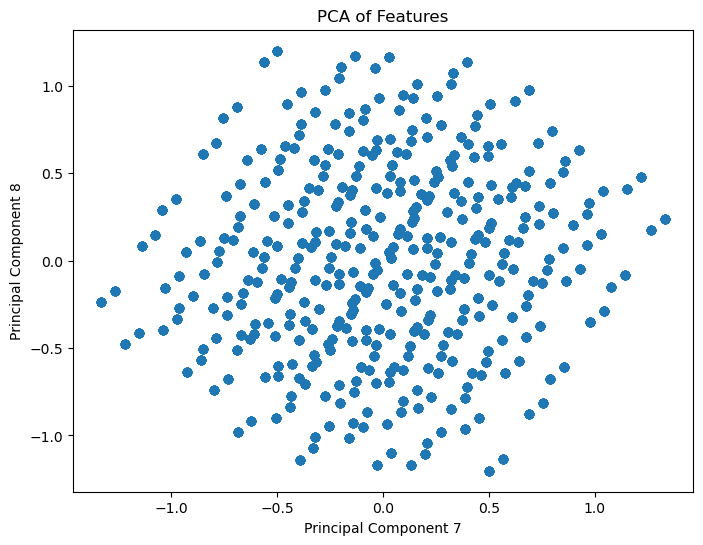

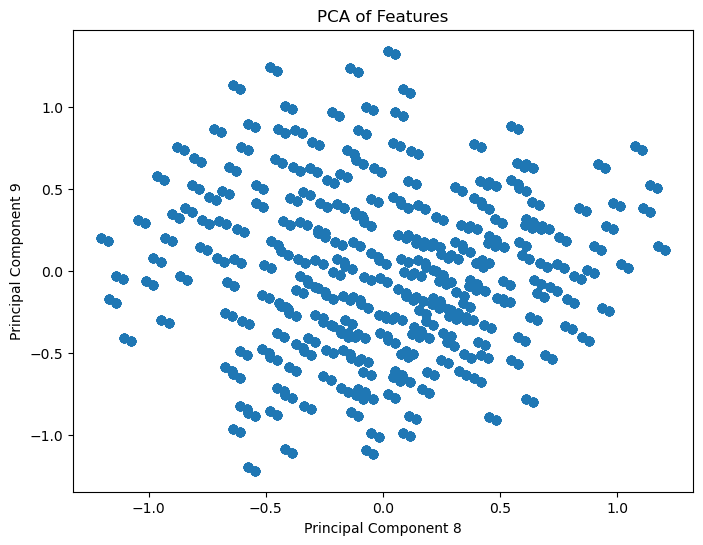

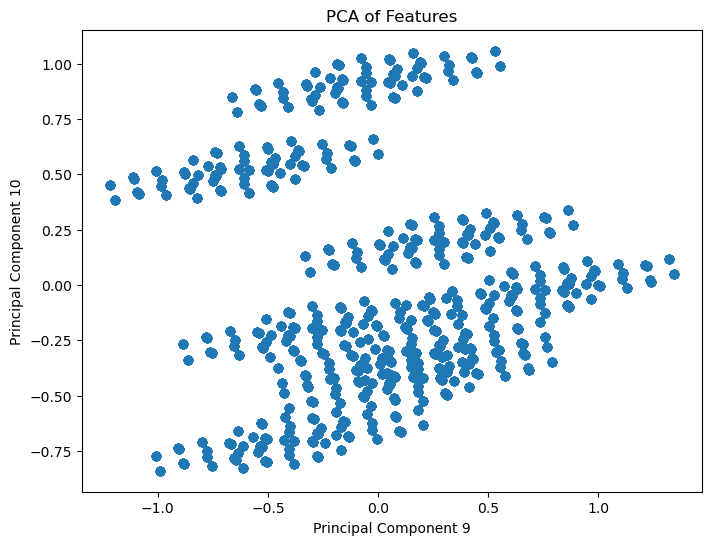

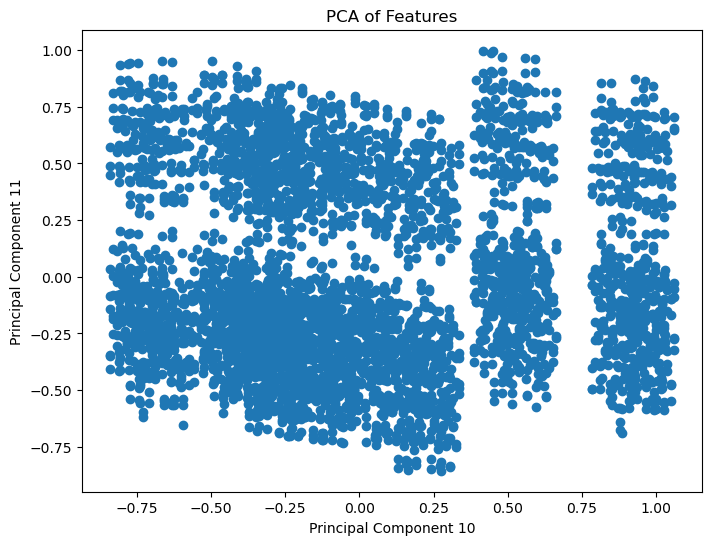

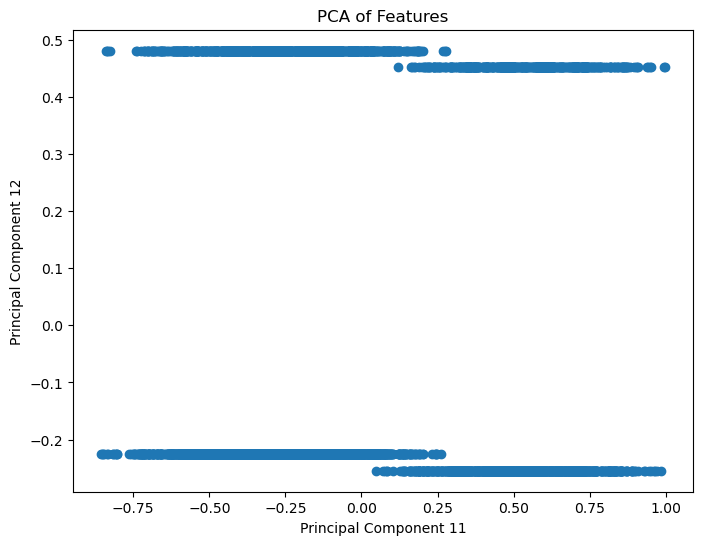

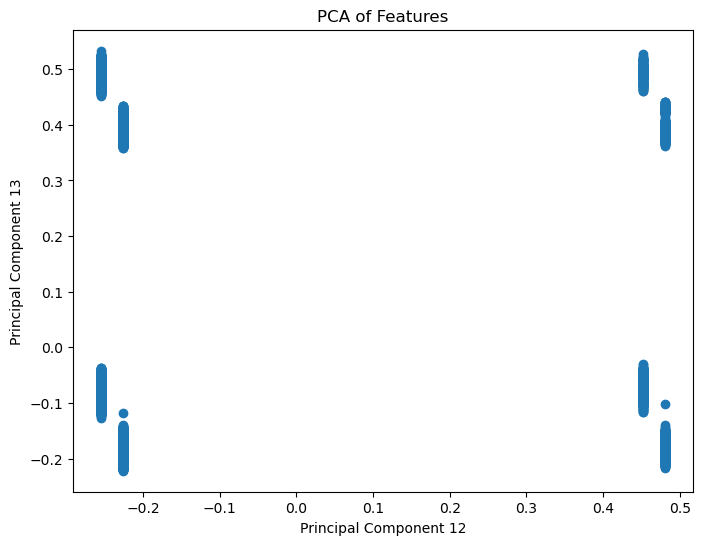

In [123]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=len(X_train.T))
#reduced_features = pca.fit_transform(X=X_train,y=y_train)
reduced_features = pca.fit_transform(measurement_df)

# Scatter plot of the first two principal components
for component in range(len(reduced_features.T)-1):
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, component], reduced_features[:, component+1])
        plt.xlabel(f'Principal Component {component}')
        plt.ylabel(f'Principal Component {component+1}')
        plt.title('PCA of Features')
        plt.show()


In [121]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.mixture import BayesianGaussianMixture

def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1], angle=180 + angle, edgecolor="black"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(2*weights[n])
        ell.set_facecolor("#0072B2")
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    #ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", color="#D55E00", alpha=0.8)
    #ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", c=y, cmap='viridis', alpha=0.8)
    ax1.scatter(X[:, 0], X[:, 15], s=5, marker="o", c=y_train, cmap='viridis', alpha=0.8)
    ax1.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    ax1.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_, estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction="out")
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(
            k,
            w,
            width=0.9,
            color="#56B4E9",
            zorder=3,
            align="center",
            edgecolor="black",
        )
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center")
    ax2.set_xlim(-0.6, 2 * n_components - 0.4)
    ax2.set_ylim(0,1)
    ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax2.tick_params(axis="x", which="both", top=False)

    if plot_title:
        ax1.set_ylabel("Estimated Mixtures")
        ax2.set_ylabel("Weight of each component")


# Parameters of the dataset
random_state, n_components, n_features = 2, 8, 16
colors = ["#0072B2", "#F0E442", "#D55E00", "#F0000", "#56B4E9", "#56B4E9"]

covars = torch.tensor(
    [[[0.7, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]]]
)
samples = torch.tensor([200, 500, 200])
means = torch.tensor([[0.0, -0.70], [0.0, 0.0], [0.0, 0.70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    (
        "Finite mixture with a Dirichlet distribution\nprior and " r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_distribution",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [0.001, 1, 1000],
    ),
    (
        "Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_process",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [1, 1000, 100000],
    ),
]

#y_train = np.array(y_train, dtype=int)
# Plot results in two different figures
for title, estimator, concentrations_prior in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(
        bottom=0.04, top=0.90, hspace=0.05, wspace=0.05, left=0.03, right=0.99
    )

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X_train)
        print(f"shape estimator.means_: {estimator.means_.shape}")
        print(f"shape estimator.covariances_: {estimator.covariances_.shape}")
        plot_results(
            plt.subplot(gs[0:2, k]),
            plt.subplot(gs[2, k]),
            estimator,
            X_train,
            y_train,
            r"%s$%.1e$" % (title, concentration),
            plot_title=k == 0,
        )

plt.show()

FloatingPointError: underflow encountered in multiply

<Figure size 1410x800 with 0 Axes>

## Kernel PCA
- look at pairwise dimensions each

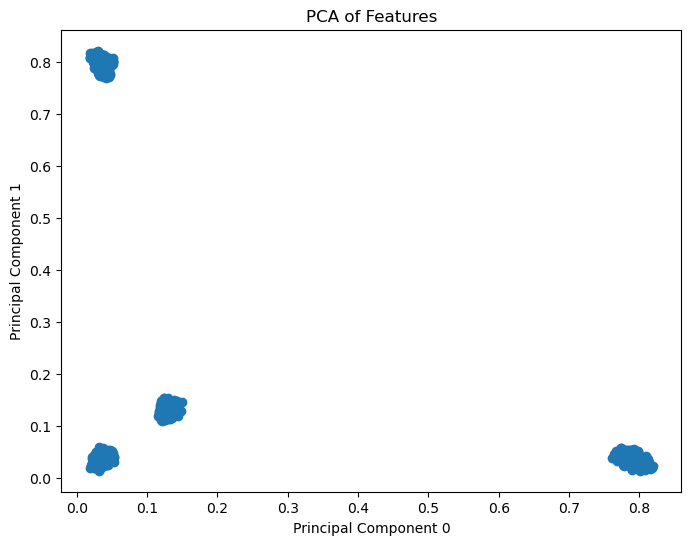

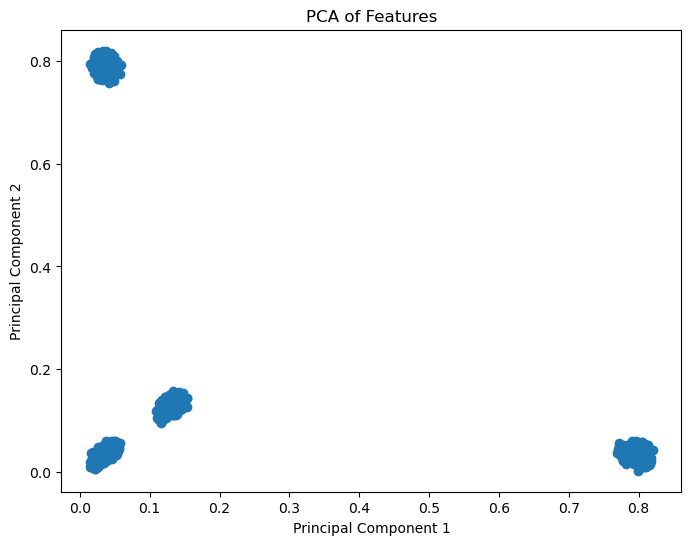

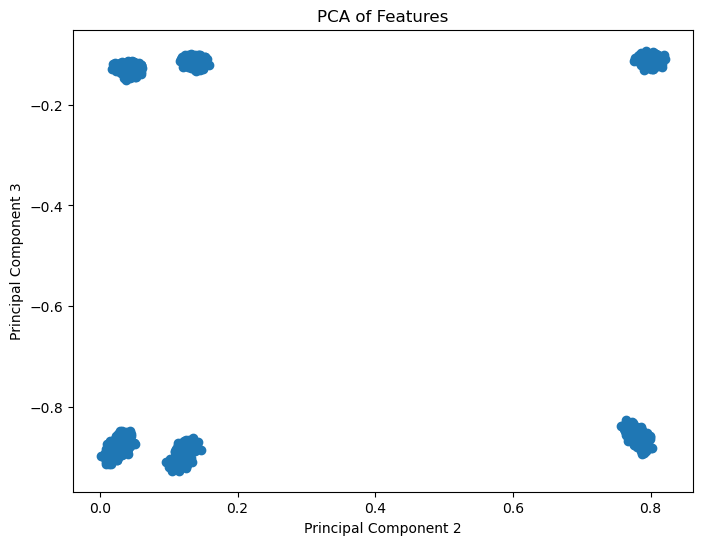

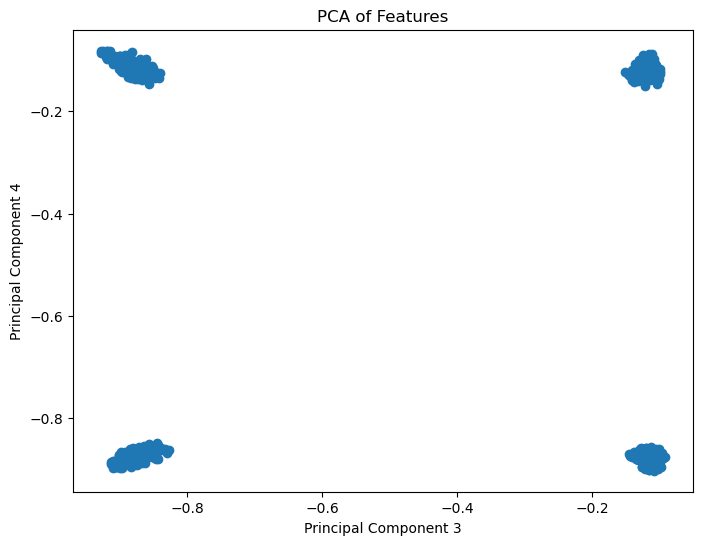

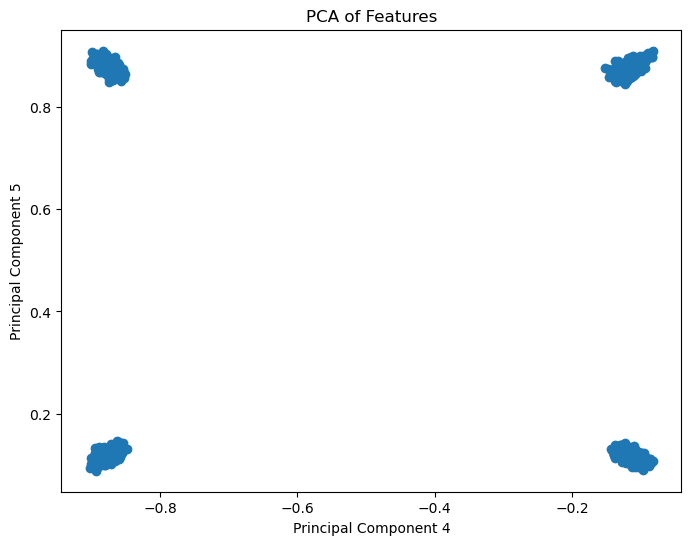

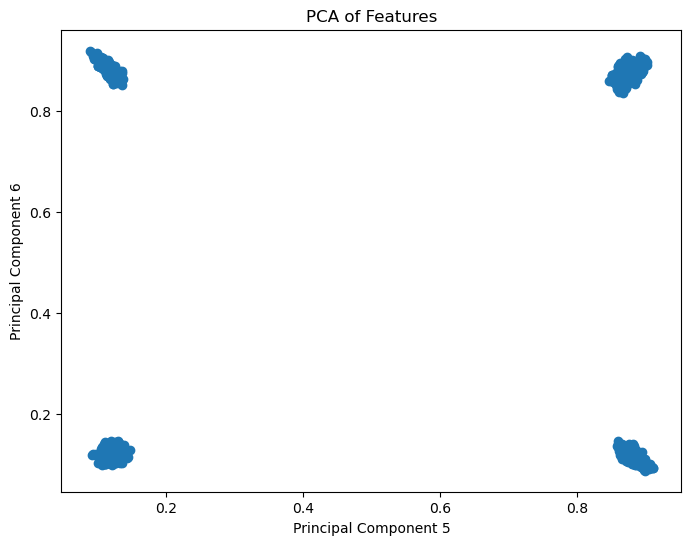

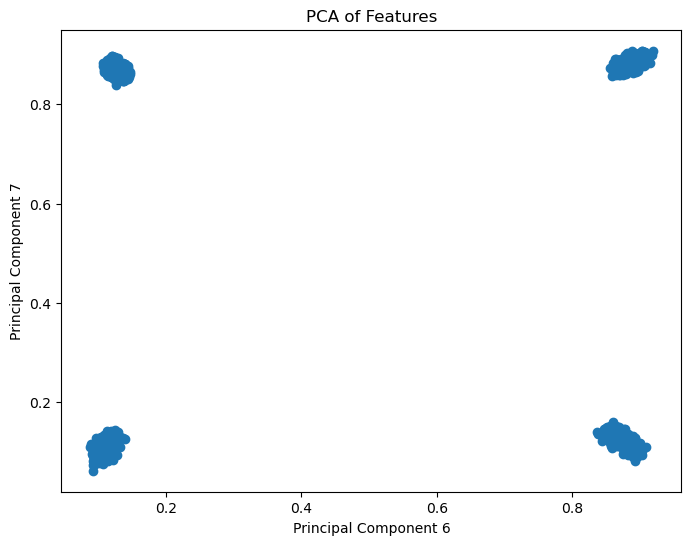

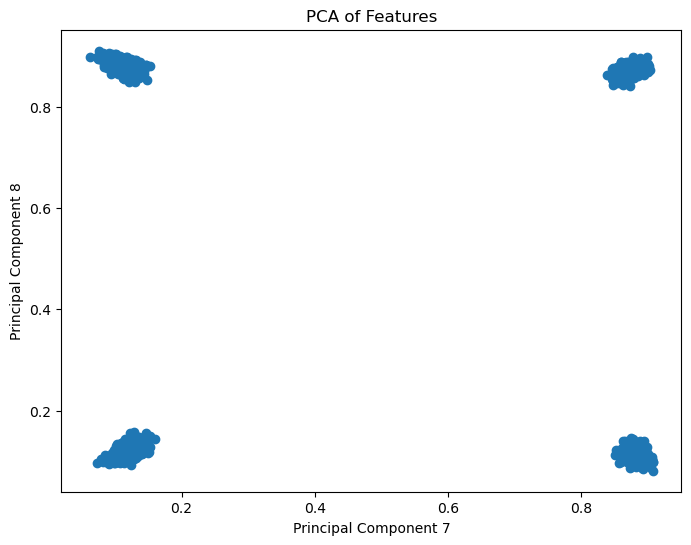

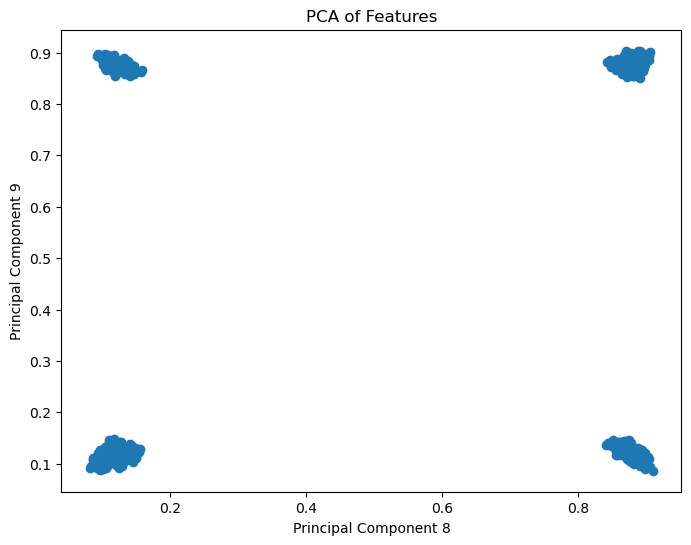

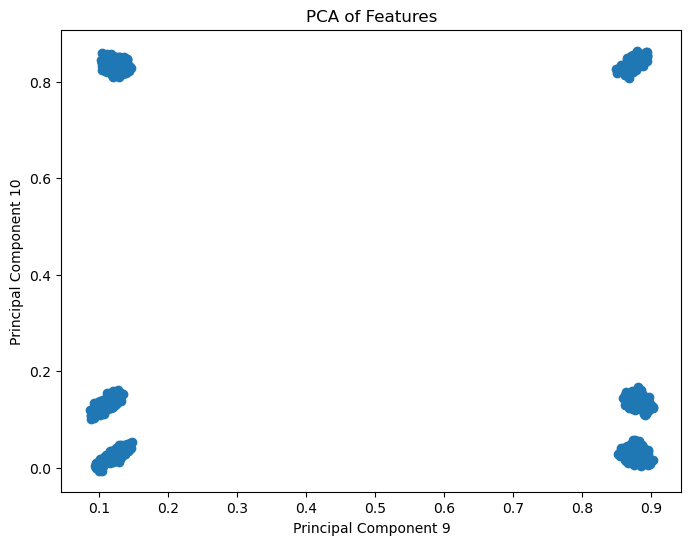

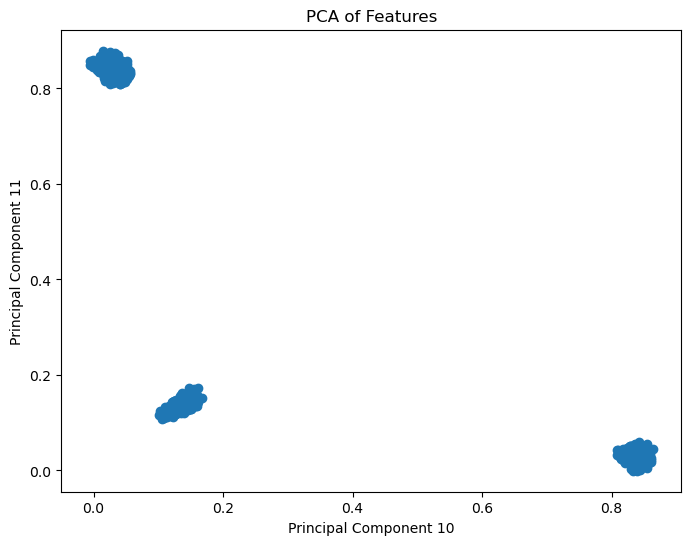

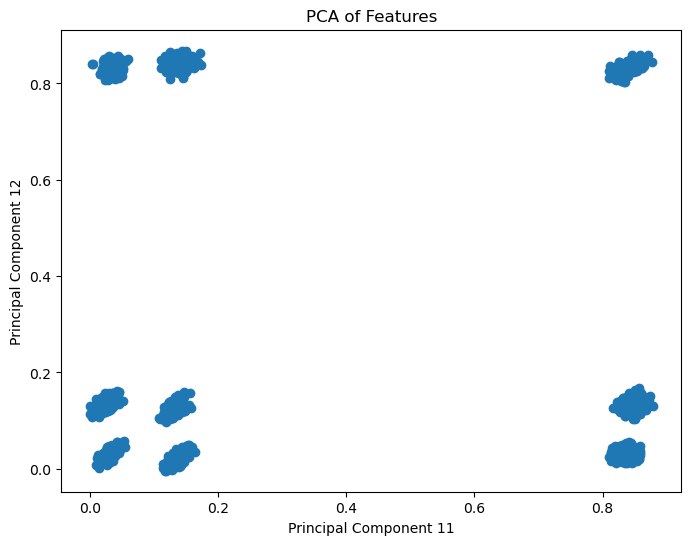

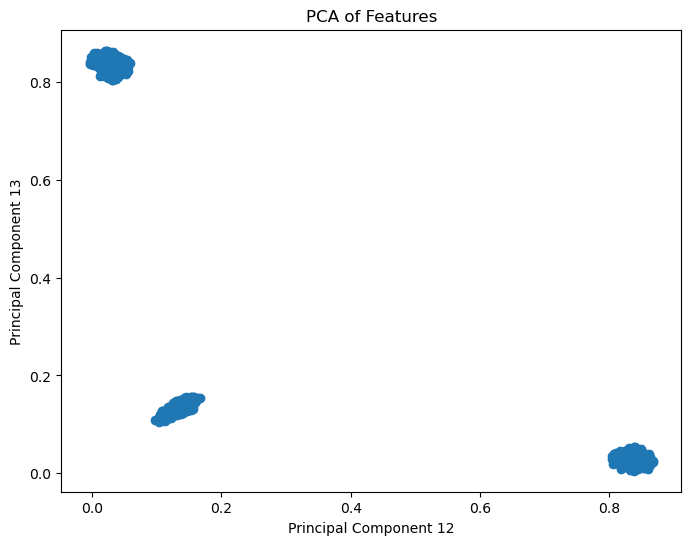

In [129]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# Perform PCA
#pca = PCA(n_components=len(X_train.T))
pca = KernelPCA(kernel="rbf", n_components=len(X_train.T), fit_inverse_transform=True)
kpca = pca.fit_transform(X=X_train,y=y_train)
reduced_features = pca.inverse_transform(kpca)

# Scatter plot of the first two principal components
for component in range(len(reduced_features.T)-1):
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, component], reduced_features[:, component+1])
        plt.xlabel(f'Principal Component {component}')
        plt.ylabel(f'Principal Component {component+1}')
        plt.title('PCA of Features')
        plt.show()


def build_masks(X, conditions):
    masks = []
    for pos, opt in conditions:
        if len(X.T) < pos < 0:
            raise ValueError("pos must be a valid index of X.")
        if type(opt) != bool and opt not in [0,1]:
            raise ValueError("opt must be a \"boolean\".")
        masks.append(X[:,pos] == opt)
    return masks

def get_words(X, masks, clause="or"):
    if clause == "or":
        return X[np.logical_or(*masks)]
    elif clause == "nor":
        return X[np.logical_not(np.logical_or(*masks))]
    elif clause == "and":
        return X[np.logical_and(*masks)]
    elif clause == "nand":
        return X[np.logical_not(np.logical_and(*masks))]
    elif clause == "xor":
        return X[np.logical_xor(*masks)]


def get_interactions(X, features):
    masks = build_masks(X, features)
    print(masks)
    interactions = get_words(X, masks, clause="and")
    return interactions

def get_opposites(X, features):
    masks = build_masks(X, features)
    print(masks)
    opposites = get_words(X, masks, clause="nand")
    return opposites

feature_interactions = [(1,0),(2,1),(3,1)]
A = get_interactions(np.array(X_train), feature_interactions)
not_A = get_opposites(np.array(X_test), feature_interactions)

print(f"A: {A}\n")
print(f"not A: {not_A}")


print("sanity check, if A and not_A are distinct")
if np.size(np.setdiff1d(A,not_A)) == 0:
    print(True)
else:
    print(False)

- using a proper kernel, the data gets linear separated and variance reduced

##### This indicates, that a Gaussian Process Regression for multivariate normal distribution among the features is suitable
https://proceedings.neurips.cc/paper_files/paper/2008/file/94c7bb58efc3b337800875b5d382a072-Paper.pdf

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import chi2_kernel, laplacian_kernel, polynomial_kernel



bayesian nonparametric model with
- Who doesn't know what the kolmogorov complexity is -> you can use a GPR for compression
- https://de.wikipedia.org/wiki/Erweiterungssatz_von_Kolmogorov
- https://de.wikipedia.org/wiki/Normierbarkeitskriterium_von_Kolmogoroff

In [4]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

X_train.shape: (20, 16)
y_train.shape: (20,)


As we see, the weight concentration prior is necessary to find a convex subspace where the GMM can converge to
This is reflected by the divergence of the GP model with constant mean.
By utilizing the empirical bayes method we can precalculate a weighted mean from the data and don't need to 
rescale otherwise. 
-> Can we find a kernel to estimate these kind of concentrations and overlap?


- ADD FORMULA FOR EMPIRICAL BAYES
- 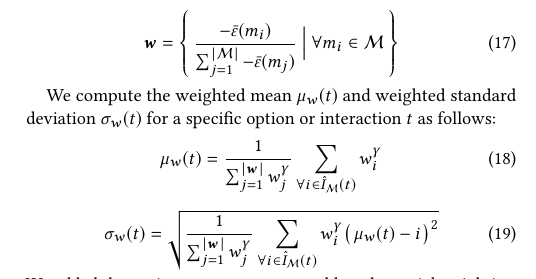

## load trained GP model

In [131]:
import torch
from domain.env import MODELDIR
from adapters.gpytorch.gp_model import SAASGP, MyExactGP


file_name = "x264_energy_fixed-energy_MCMC_matern52_simple_20_20240528-195232" 

model = file_name.split("_")[-5] if not "piecewise_polynomial" in file_name or "spectral_mixture" in file_name else file_name.split("_")[-6]
kernel_type = file_name.split("_")[-4] if not "piecewise_polynomial" in file_name or "spectral_mixture" in file_name else file_name.split("_")[-5] + "_" + file_name.split("_")[-4]
kernel_structure = file_name.split("_")[-3]
training_size = int(file_name.split("_")[-2])
sws = "_".join(file_name.split("_")[:-6]) # take all tokens before the model type
y_type = file_name.split("_")[-6]
use_synthetic_data = False if "synthetic" not in sws else True
print(f"sws: {sws}")

model_file = f"{MODELDIR}/{file_name}.pth"
data = get_data(use_synthetic_data=use_synthetic_data, inference=model, sws=sws, y_type=y_type, training_size=training_size)
ds, X_train, X_test, y_train, y_test, feature_names = data

# init model and load state dict
if model == "exact":
    model = MyExactGP(X_train, y_train, feature_names, likelihood="gaussian", kernel=kernel_type, mean_func="linear_weighted", structure=kernel_structure)
elif model == "MCMC":
    model = SAASGP(X_train, y_train, feature_names, mean_func="constant", kernel_structure=kernel_structure, kernel_type=kernel_type)
    model.eval()
    print(model)
model.load_state_dict(torch.load(model_file), strict=False)
print(model)
model.eval()


sws: x264_energy
Checking if x264_energy isn't already extracted
   root  no_asm  no_8x8dct  no_cabac  no_deblock  no_fast_pskip  no_mbtree  \
0     1       1          1         1           1              1          1   
1     1       1          1         1           1              1          1   
2     1       1          1         1           1              1          1   
3     1       1          1         1           1              1          1   
4     1       1          1         1           1              1          1   

   no_mixed_refs  no_weightb  rc_lookahead  ...  fixed-energy  \
0              1           1             1  ...        4.9908   
1              1           1             1  ...        5.1394   
2              1           1             1  ...        5.2798   
3              1           1             1  ...        5.0838   
4              1           1             1  ...        5.3794   

   benchmark-energy  benchmark-iperf  fixed-cpu  benchmark-cpu  \
0        

/home/immanuel/.conda/envs/bayesrisk/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning:

Input data is not standardized (mean = tensor([5.5311], dtype=torch.float64), std = tensor([0.3828], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.



In [106]:
model.eval()
with torch.no_grad():
    posterior = model.posterior(X_test)
    confidence_region = posterior.mvn.confidence_region()

    # create dimensional model
    dims = len(model.X.T)
    dimensional_model = {}
    for dim in range(dims):
        dimensional_model[dim] = {}
        dimensional_model[dim]["X"] = X_train[:, dim]
        dimensional_model[dim]["feature_name"] = feature_names[dim]
        dimensional_model[dim]["y"] = y_train
        dimensional_model[dim]["X_test"] = X_test[:, dim]
        dimensional_model[dim]["mean"] = posterior.mean[dim]
        dimensional_model[dim]["variance"] = posterior.variance[dim]
        dimensional_model[dim]["std"] = torch.sqrt(posterior.variance[dim])
        dimensional_model[dim]["covariance"] = posterior.covariance_matrix[dim]
        dimensional_model[dim]["lower"] = confidence_region[0][dim]
        dimensional_model[dim]["upper"] = confidence_region[1][dim]

print(f"shape of mean: {dimensional_model[0]['mean'].shape}")
print(f"shape of covariance: {dimensional_model[0]['covariance'].shape}")

shape of mean: torch.Size([20, 1])
shape of covariance: torch.Size([20, 20])


In [107]:
from adapters.gpytorch.util import decompose_matrix, get_beta, get_thetas
from domain.feature_model.feature_modeling import inverse_map
import numpy as np

CONFIDENCE = 0.95

mean_vector = posterior.mvn.mean if isinstance(model, MyExactGP) else dimensional_model[0]["mean"] # example for first dimension
cov_matrix = posterior.mvn.covariance_matrix if isinstance(model, MyExactGP) else dimensional_model[0]["covariance"] # example for first dimension
U, lam, V = decompose_matrix(cov_matrix)
# inference according to BAKR https://github.com/lorinanthony/BAKR/blob/master/Tutorial/BAKR_Tutorial.R
explained_var = np.cumsum(np.array(lam) / np.sum(np.array(lam)))
p = len(model.X.T)
# estimate, how much of the explained variance is explained by p components
p_explained_var = explained_var[p - 1]
print(f"{p_explained_var}.2f of the variance is explained by {p} components (the base features)")
q = np.where(explained_var >= CONFIDENCE)[0][0] + 1 # number of principal components to explain confidential proportion of variance
#qq = next(x[0] for x in enumerate(explained_var) if x[1] > CONFIDENCE) + 1
#qqq = next(i + 1 for i, var in enumerate(explained_var) if var >= CONFIDENCE)
Lambda = np.diag(np.sort(lam)[::-1])[:q] # diagonal matrix with first q eigenvalues 
full_latent_space = U @ lam @ V.T # full latent space
U = U[:, :q] # first q columns
B = inverse_map(model.X.T, U) # inverse map of the latent space with p x q
Laplace_approximation = B @ B.T
# project the latent space from a fixed column to all other columns with granularity q
thetas = get_thetas(cov_matrix, q)
betas = get_beta(B, thetas)

<class 'torch.Tensor'> is full rank and square. Rank(X) = 20
0.9838283582763262.2f of the variance is explained by 14 components (the base features)
<class 'torch.Tensor'> is full rank and square. Rank(X) = 20
i = 0
B.shape = torch.Size([14, 11])
thetamat.shape = torch.Size([20, 11])
betamat[:, i] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
betamat[:, i].shape = (14,)
thetamat[i, :] = tensor([-0.0026, -0.0372, -0.0341, -0.0015, -0.0011,  0.0120, -0.0351, -0.0026,
         0.0032, -0.0310, -0.0326], dtype=torch.float64)
thetamat[i, :].shape = torch.Size([11])


/home/immanuel/Dokumente/Master Thesis/dev/energy-influence-model-structure-uncertainty/domain/feature_model/feature_modeling.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
/home/immanuel/Dokumente/Master Thesis/dev/energy-influence-model-structure-uncertainty/domain/feature_model/feature_modeling.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U = torch.tensor(U)


## dimension wise interactions

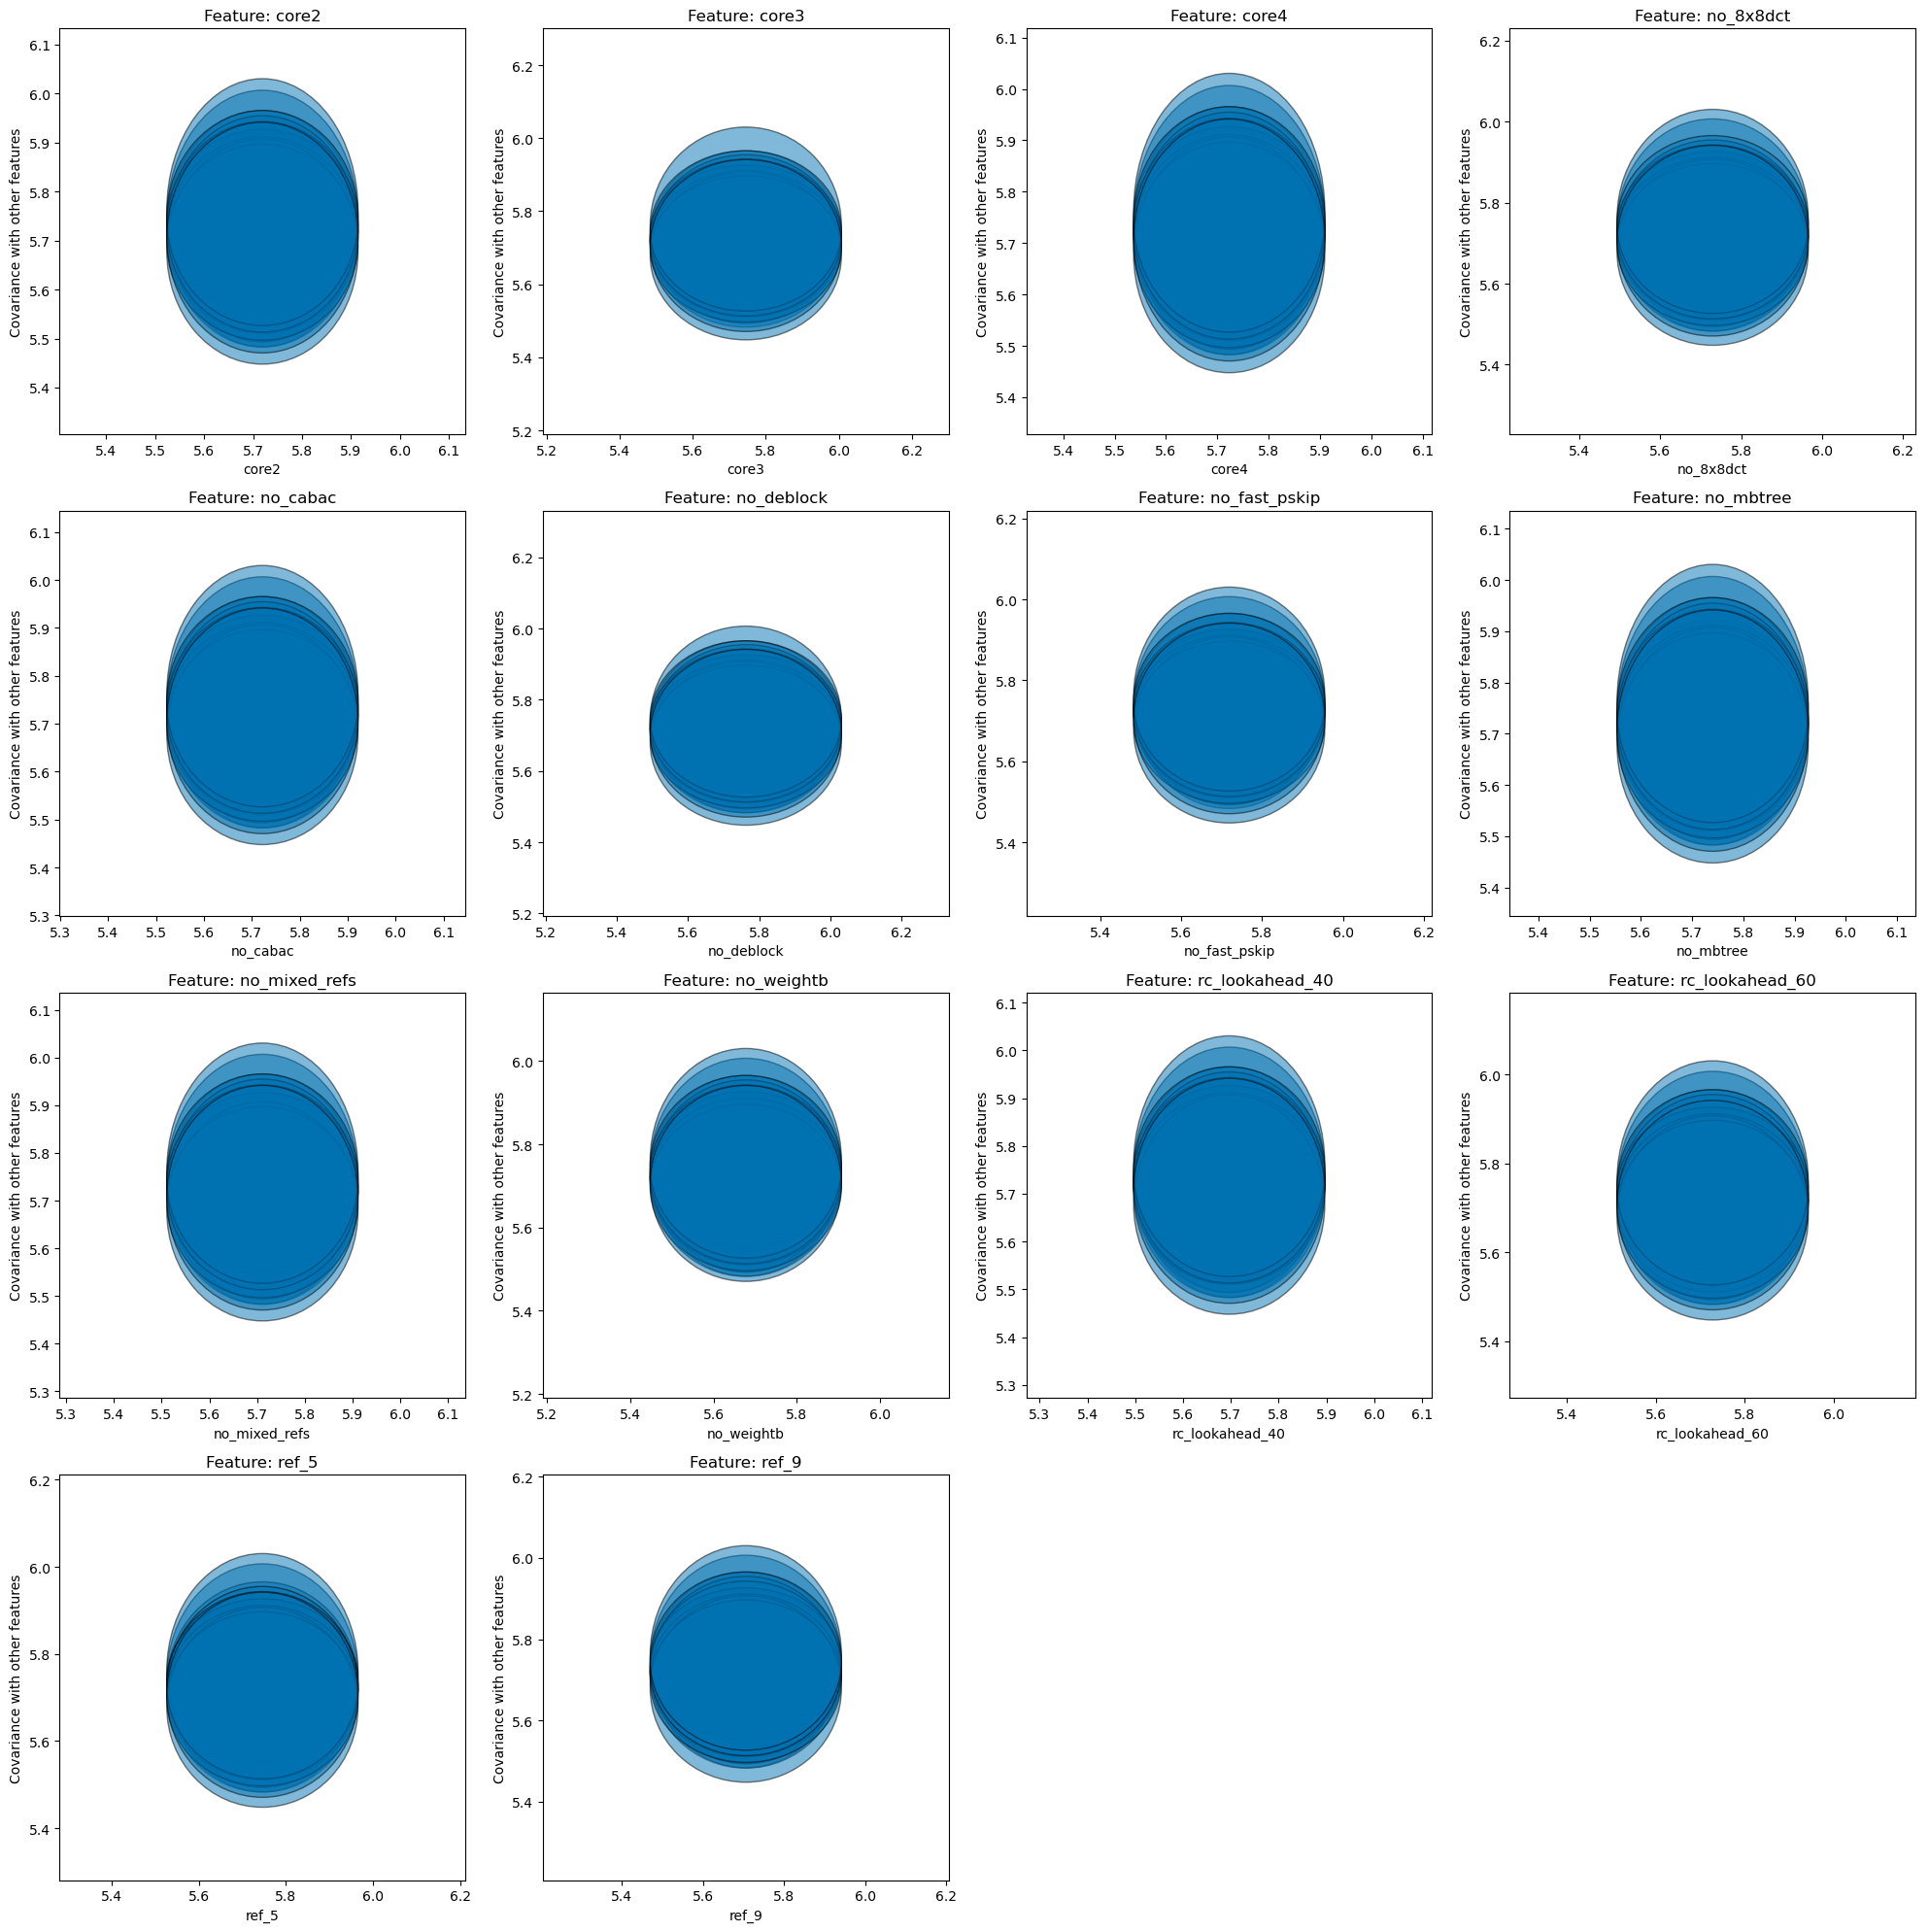

In [108]:
import matplotlib as mpl
from matplotlib import pyplot as plt

def plot_ellipses_in_grid(dimensional_model, rows=2, edge_color='black', fill_color='#0072B2', fill_alpha=0.5):
    """
    Plots ellipses representing covariance for each feature against all other features in a grid layout.
    
    Args:
    - dimensional_model: Dictionary containing model information for each dimension.
    - rows: Number of rows in the grid of subplots.
    - edge_color: Color of the ellipse edge.
    - fill_color: Fill color of the ellipse.
    - fill_alpha: Alpha value for the fill color to control transparency.
    """
    num_features = len(dimensional_model)
    cols = (num_features + rows - 1) // rows  # Calculate the required number of columns for the grid
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)
    
    for i in range(num_features):
        row, col = divmod(i, cols)
        ax = axes[row, col]
        feature_name_i = dimensional_model[i]["feature_name"]
        mean_i = dimensional_model[i]["mean"].mean().item()
        variance_i = dimensional_model[i]["variance"].median().item()
        
        for j in range(num_features):
            if i != j:
                feature_name_j = dimensional_model[j]["feature_name"]
                mean_j = dimensional_model[j]["mean"].mean().item()
                variance_j = dimensional_model[j]["variance"].median().item()
                
                cov_matrix_2x2 = np.array([[variance_i, 0], [0, variance_j]])
                eig_vals, eig_vecs = np.linalg.eigh(cov_matrix_2x2)
                angle = np.degrees(np.arctan2(eig_vecs[1, 0], eig_vecs[0, 0]))
                width, height = 2 * np.sqrt(2) * np.sqrt(eig_vals)
                
                ellipse = mpl.patches.Ellipse(xy=(mean_i, mean_j), width=width, height=height, angle=angle,
                                          edgecolor=edge_color, facecolor=fill_color, alpha=fill_alpha)
                ax.add_patch(ellipse)
        
        ax.set_xlim(mean_i - 3 * np.sqrt(variance_i), mean_i + 3 * np.sqrt(variance_i))
        ax.set_ylim(mean_i - 3 * np.sqrt(variance_i), mean_i + 3 * np.sqrt(variance_i))
        ax.set_xlabel(feature_name_i)
        ax.set_ylabel('Covariance with other features')
        ax.set_title(f'Feature: {feature_name_i}')
        ax.set_aspect('equal')
    
    # Turn off any unused subplots
    for i in range(num_features, rows * cols):
        row, col = divmod(i, cols)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

plot_ellipses_in_grid(dimensional_model, rows=4)

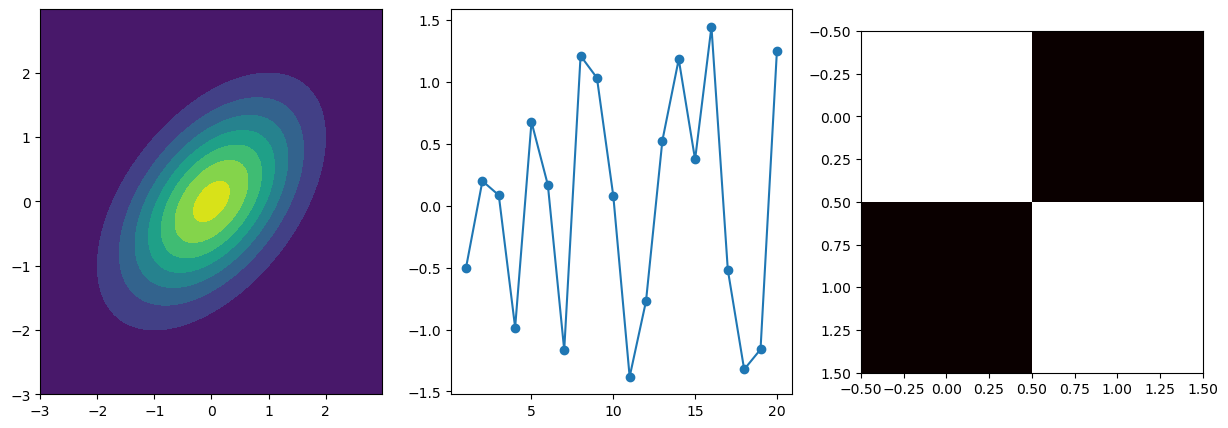

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# For reproducibility
np.random.seed(42)

# Example mean and covariance for a 2D Gaussian
mu = np.array([0, 0])
cov = np.array([[1, 0.5], [0.5, 1]])

# Create grid and multivariate normal
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mu, cov)

# Make the plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Contour plot
ax[0].contourf(x, y, rv.pdf(pos))

# Line plot for a sample path
t = np.linspace(1, 20, 20)
y_sample = np.random.multivariate_normal(mu, cov, size=t.shape[0])
ax[1].plot(t, y_sample[:, 1], '-o')

# Heatmap of the covariance matrix
ax[2].imshow(cov, cmap='hot', interpolation='nearest')

plt.show()



## Inspecting the covariance matrix

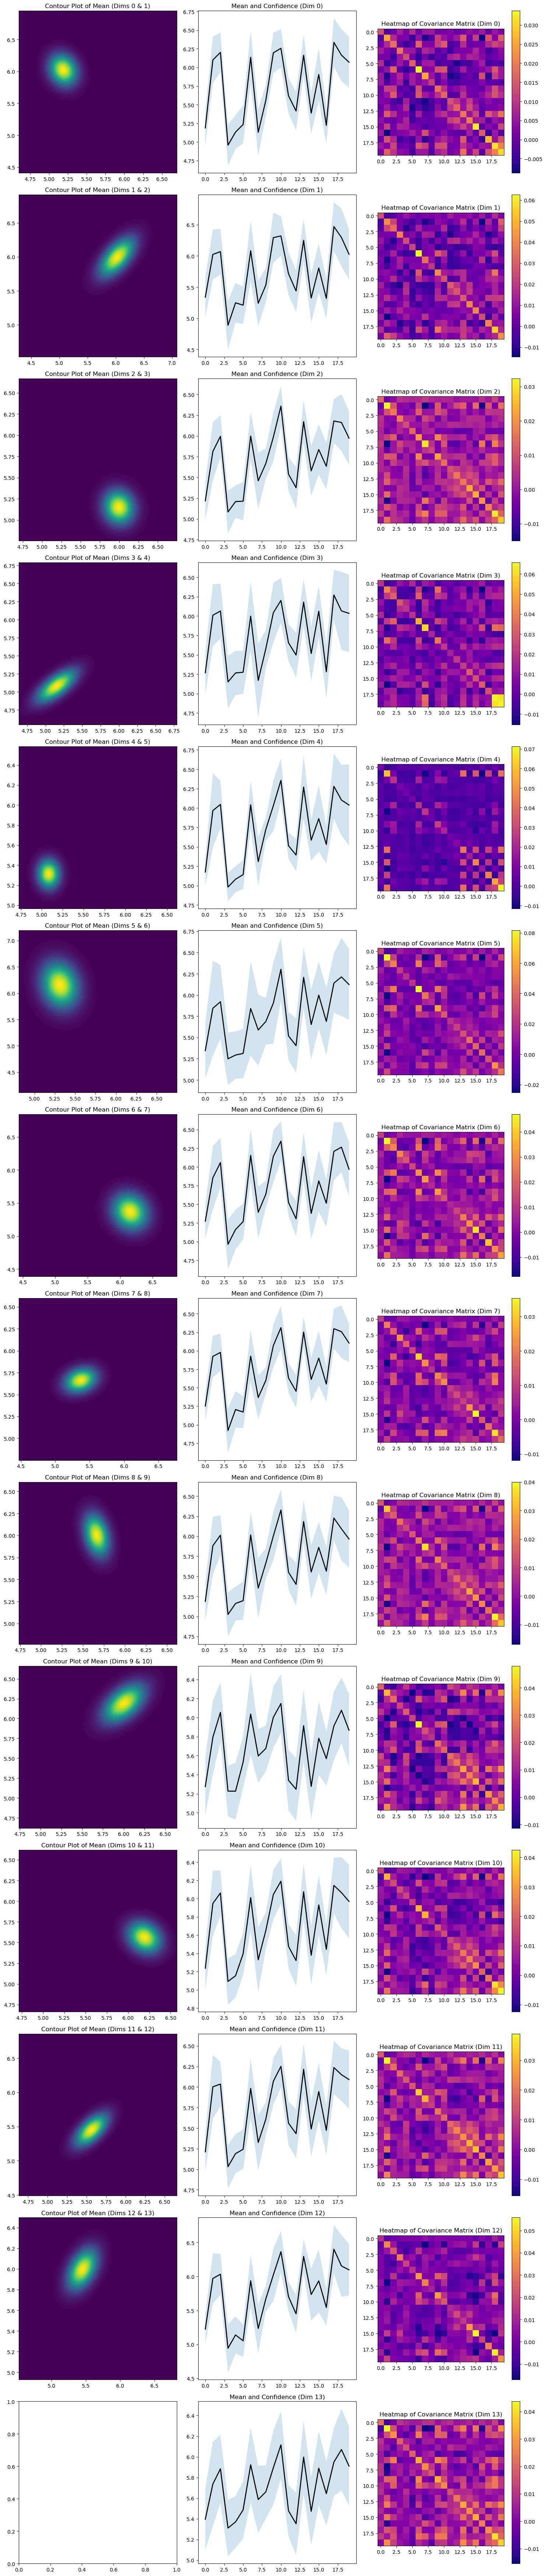

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch

# Assuming dimensional_model is defined with "mean" and "covariance" for each dimension

# Number of dimensions in your model
num_dims = len(dimensional_model)

# Prepare the figure with a grid of subplots
fig, axs = plt.subplots(num_dims, 3, figsize=(15, 5 * num_dims))

# Iterate over each dimension pair
for i in range(num_dims):
    # Mean and covariance for the current dimension
    mean_i = dimensional_model[i]["mean"].squeeze(-1).numpy()  # Squeeze to make it 1D
    cov_i = dimensional_model[i]["covariance"].numpy()

    # Contour plot for the mean of two dimensions
    if i < num_dims - 1:  # Ensure there is a next dimension to pair with
        mean_j = dimensional_model[i + 1]["mean"].squeeze().numpy()
        
        # Choose appropriate grid limits
        grid_x_min, grid_x_max = mean_i.min() - 3 * np.sqrt(cov_i[i, i]), mean_i.max() + 3 * np.sqrt(cov_i[i, i])
        grid_y_min, grid_y_max = mean_j.min() - 3 * np.sqrt(cov_i[i + 1, i + 1]), mean_j.max() + 3 * np.sqrt(cov_i[i + 1, i + 1])
        
        xi, yi = np.meshgrid(np.linspace(grid_x_min, grid_x_max, 100), np.linspace(grid_y_min, grid_y_max, 100))
        
        # Extract the covariance entries for just these two dimensions
        cov_ij = np.array([
            [cov_i[i, i], cov_i[i, i + 1]],
            [cov_i[i + 1, i], cov_i[i + 1, i + 1]]
        ])
        
        # Create a bivariate normal distribution
        rv_ij = multivariate_normal([mean_i[i], mean_j[i + 1]], cov_ij)
        
        # Compute the PDF over the grid and plot the contour
        zi = rv_ij.pdf(np.dstack((xi, yi)))
        axs[i, 0].contourf(xi, yi, zi, levels=100)
        axs[i, 0].set_title(f'Contour Plot of Mean (Dims {i} & {i+1})')


    # Line plot for the mean and confidence interval of the current dimension
    std_dev_i = np.sqrt(np.diag(cov_i))
    axs[i, 1].plot(mean_i, 'k-', lw=2)
    axs[i, 1].fill_between(range(len(mean_i)), mean_i - 1.96 * std_dev_i, mean_i + 1.96 * std_dev_i, alpha=0.2)
    axs[i, 1].set_title(f'Mean and Confidence (Dim {i})')

    # Heatmap of the covariance matrix for the current dimension
    im = axs[i, 2].imshow(cov_i, cmap='plasma', interpolation='nearest')
    fig.colorbar(im, ax=axs[i, 2])
    axs[i, 2].set_title(f'Heatmap of Covariance Matrix (Dim {i})')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


## Inspecting the precision matrix

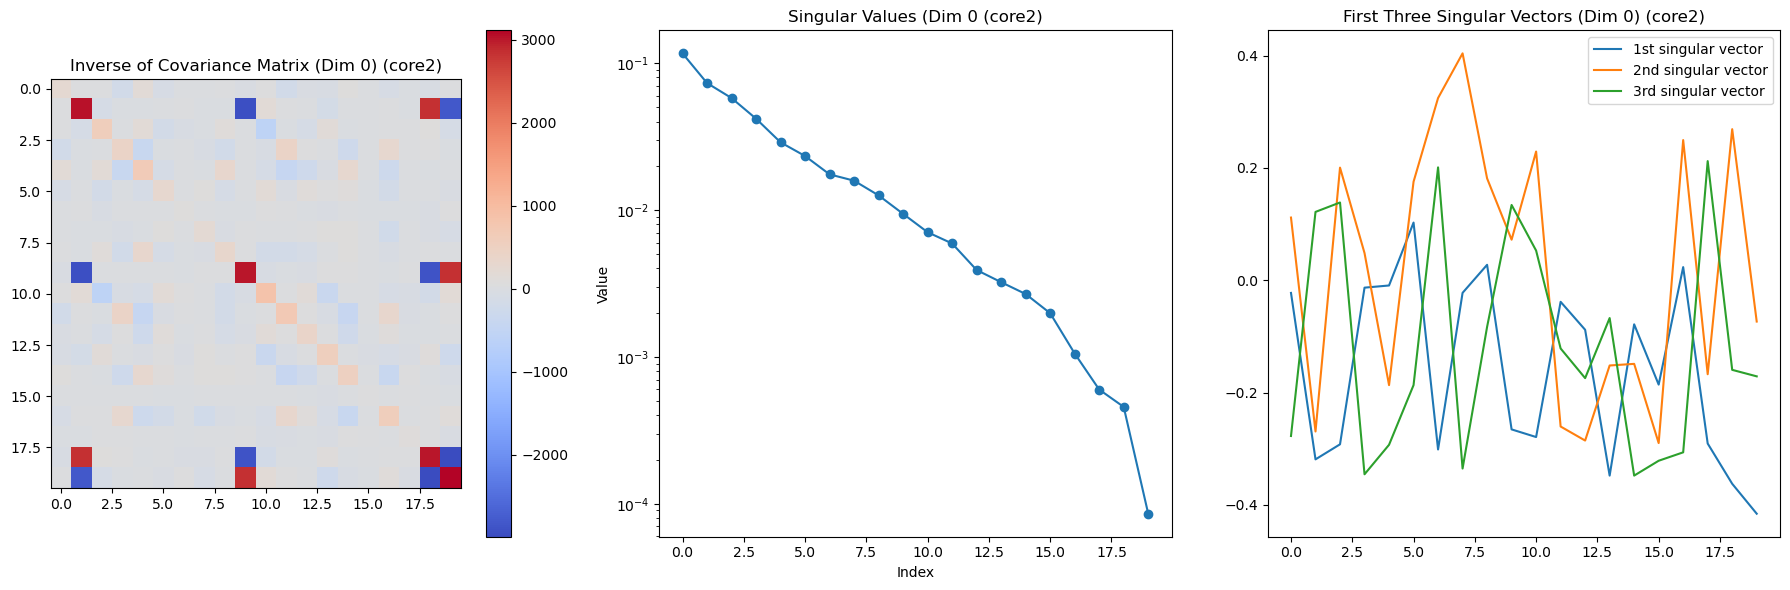

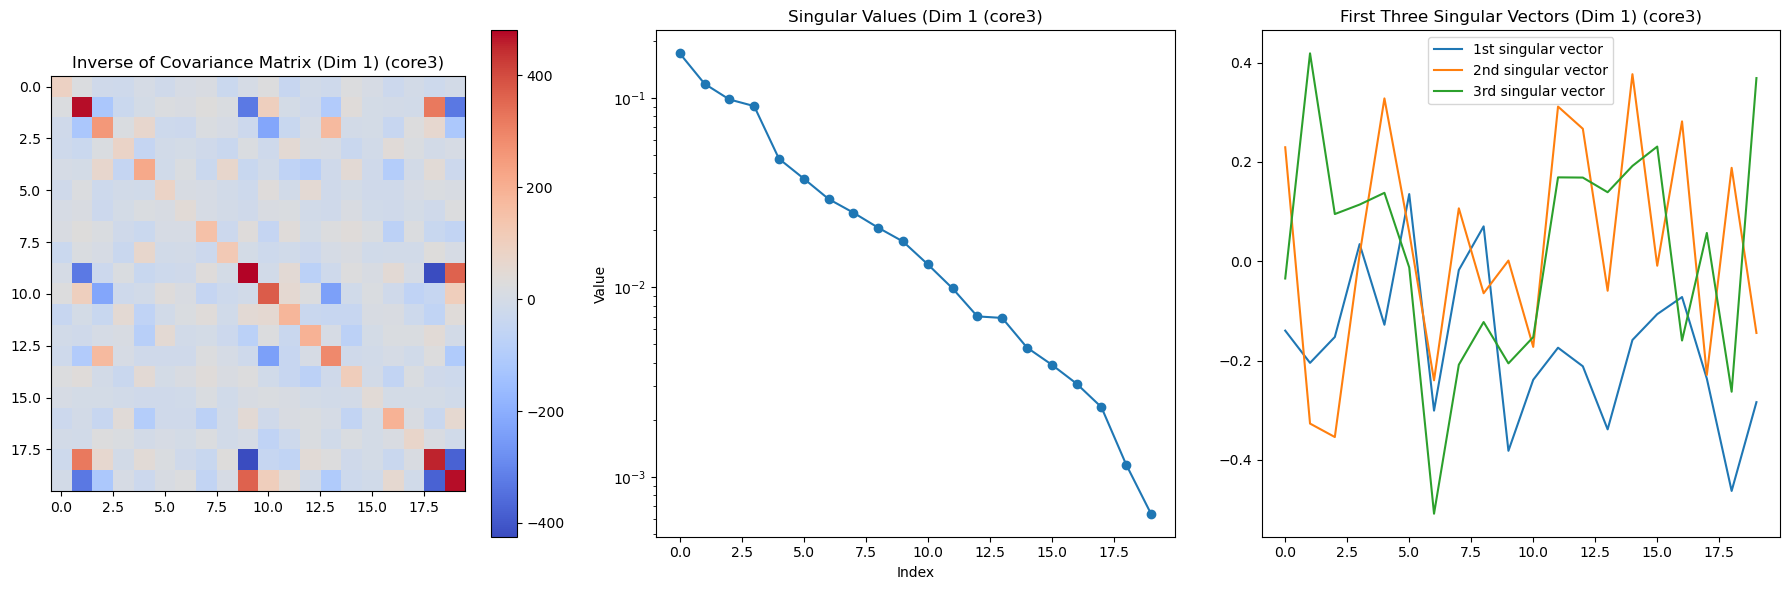

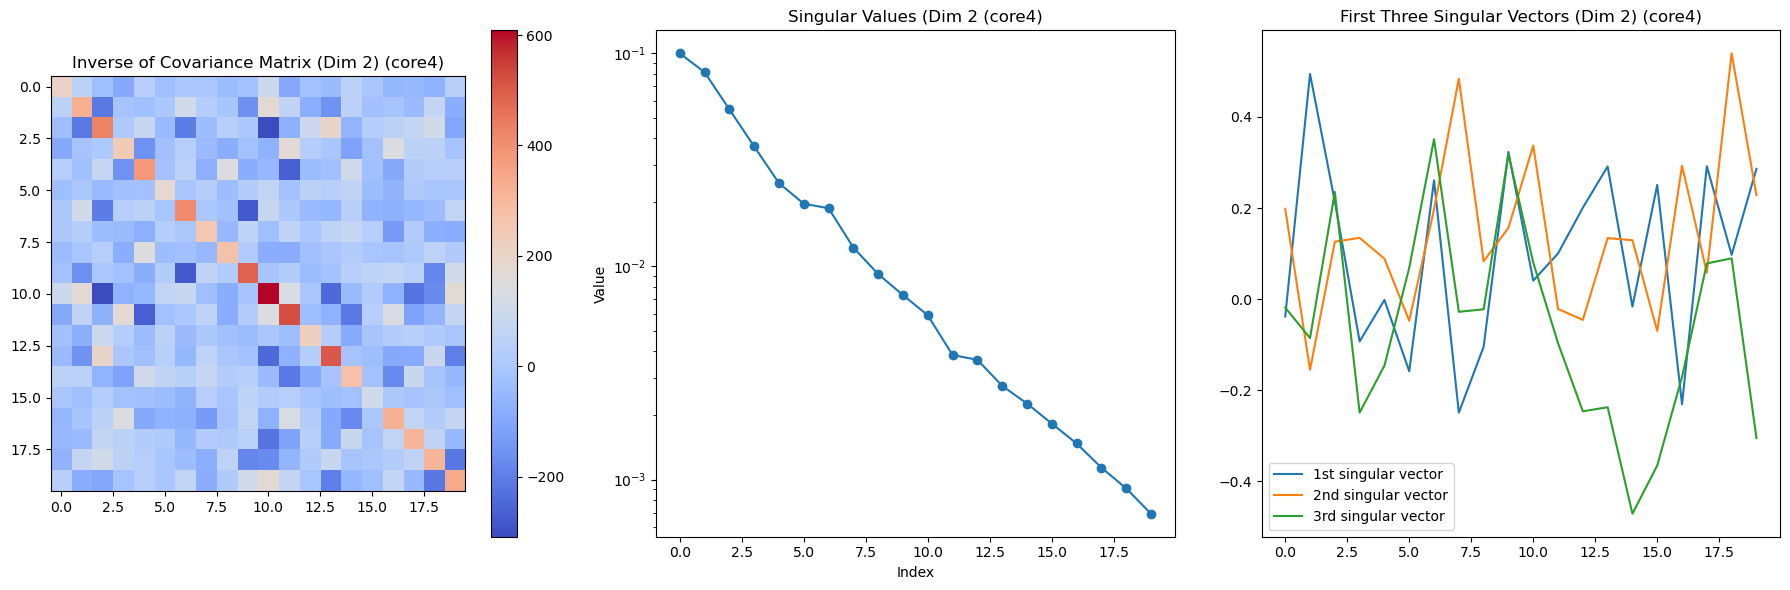

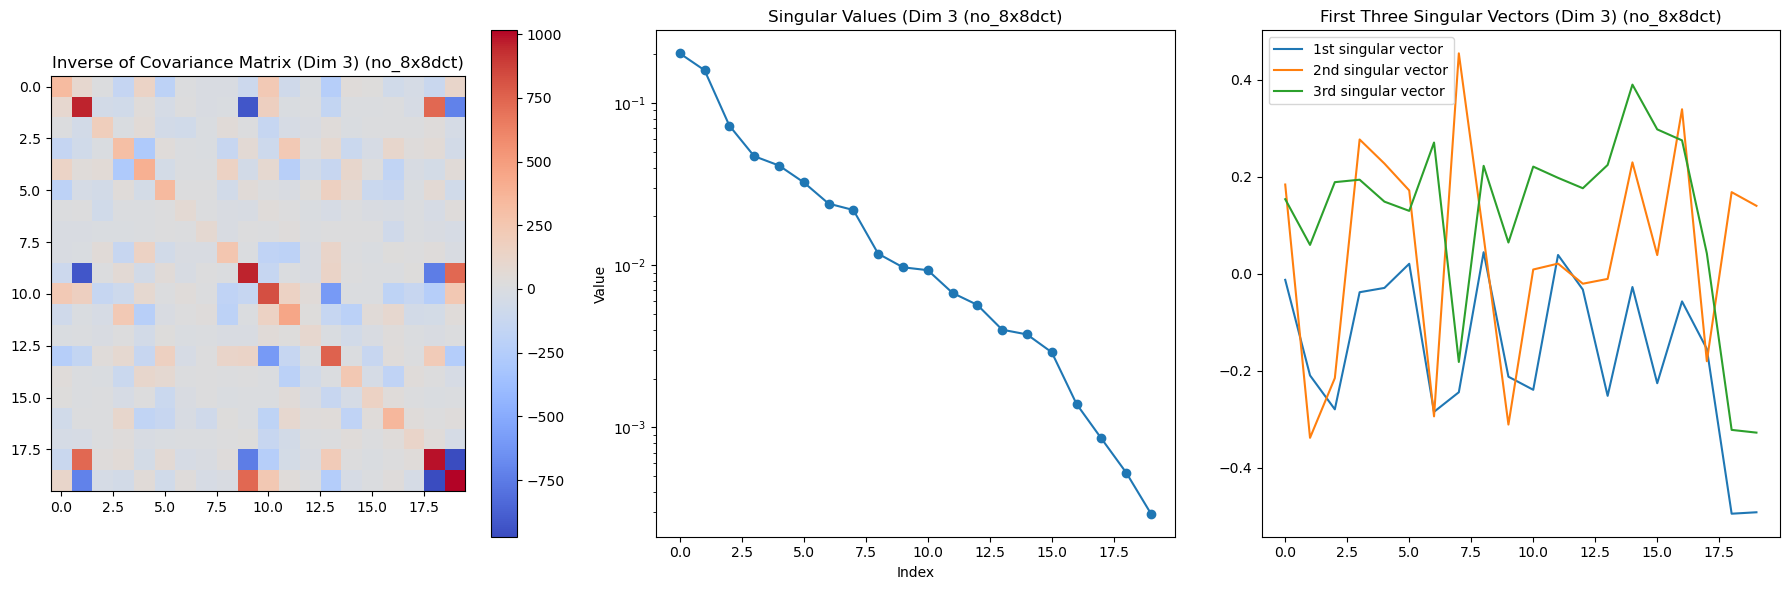

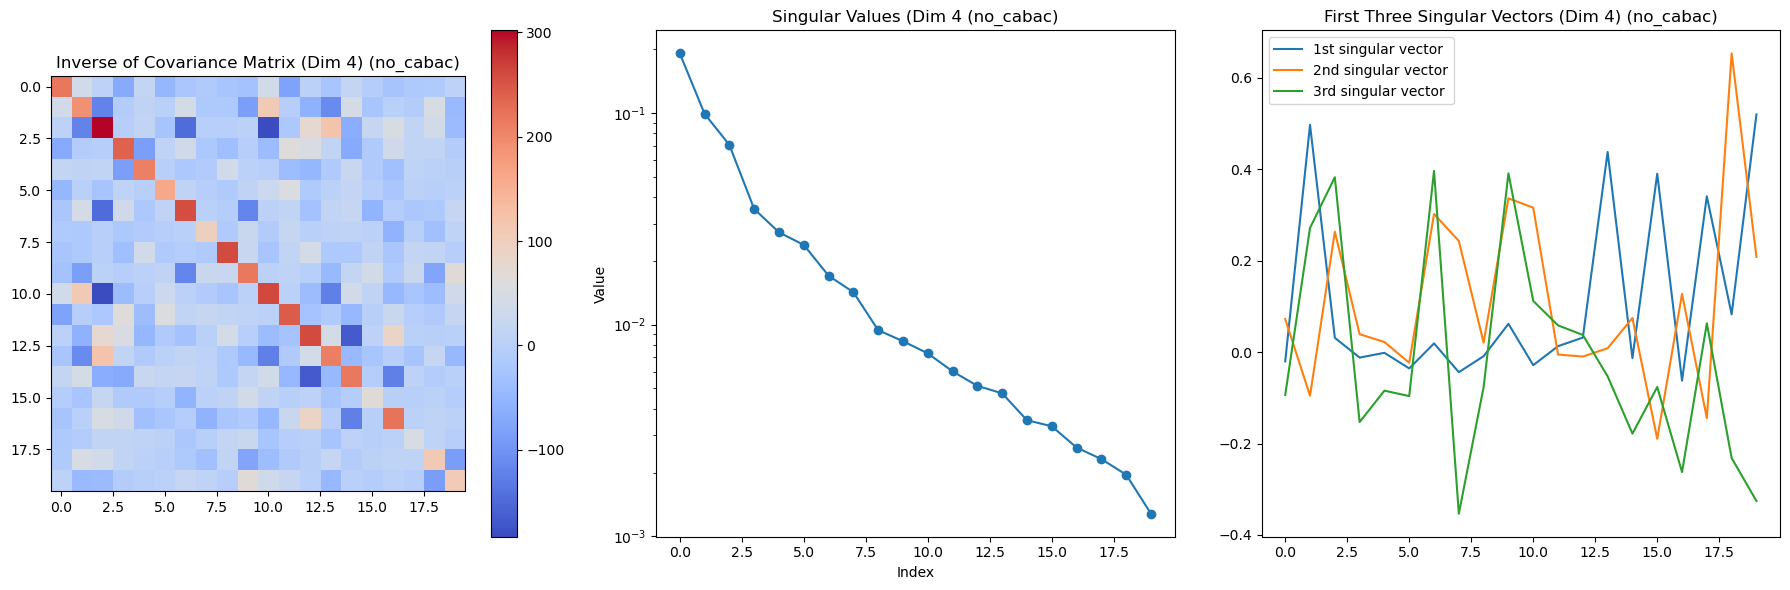

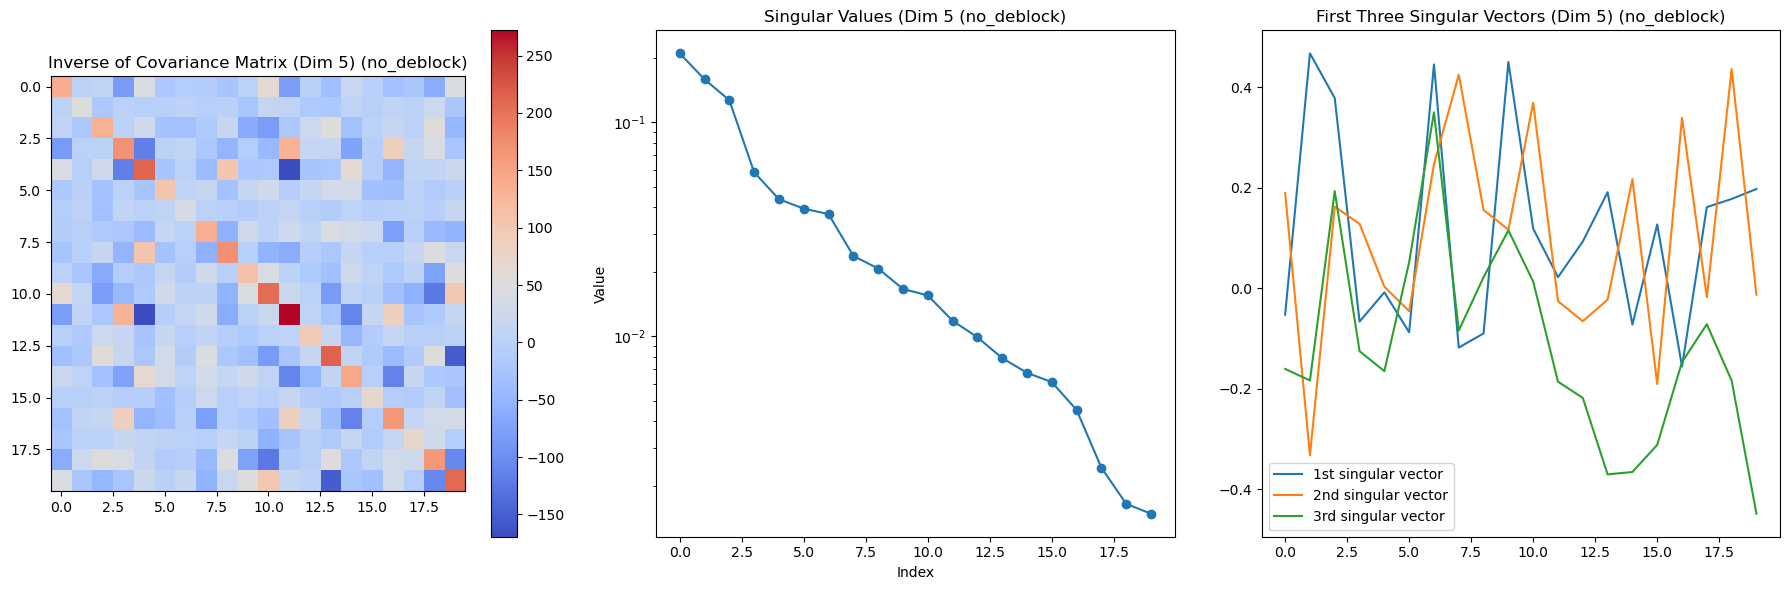

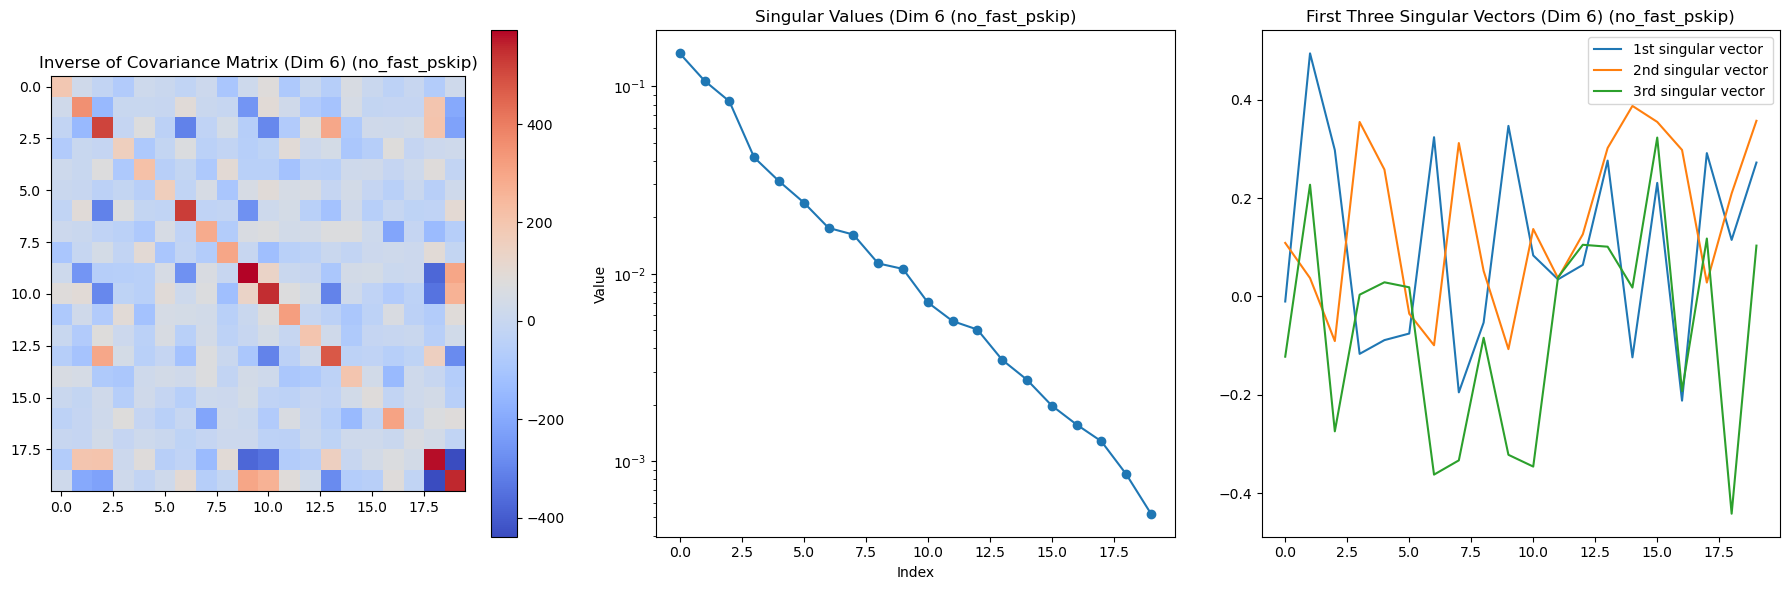

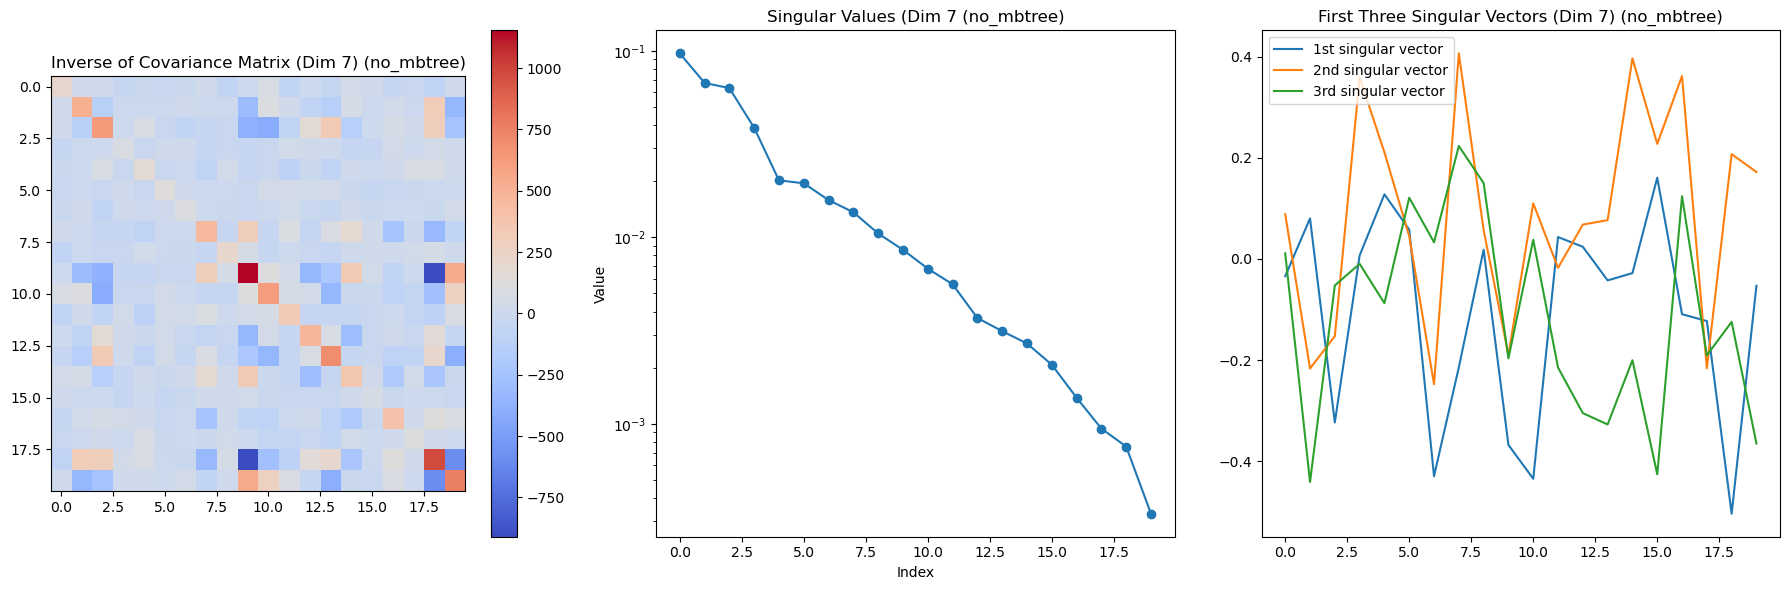

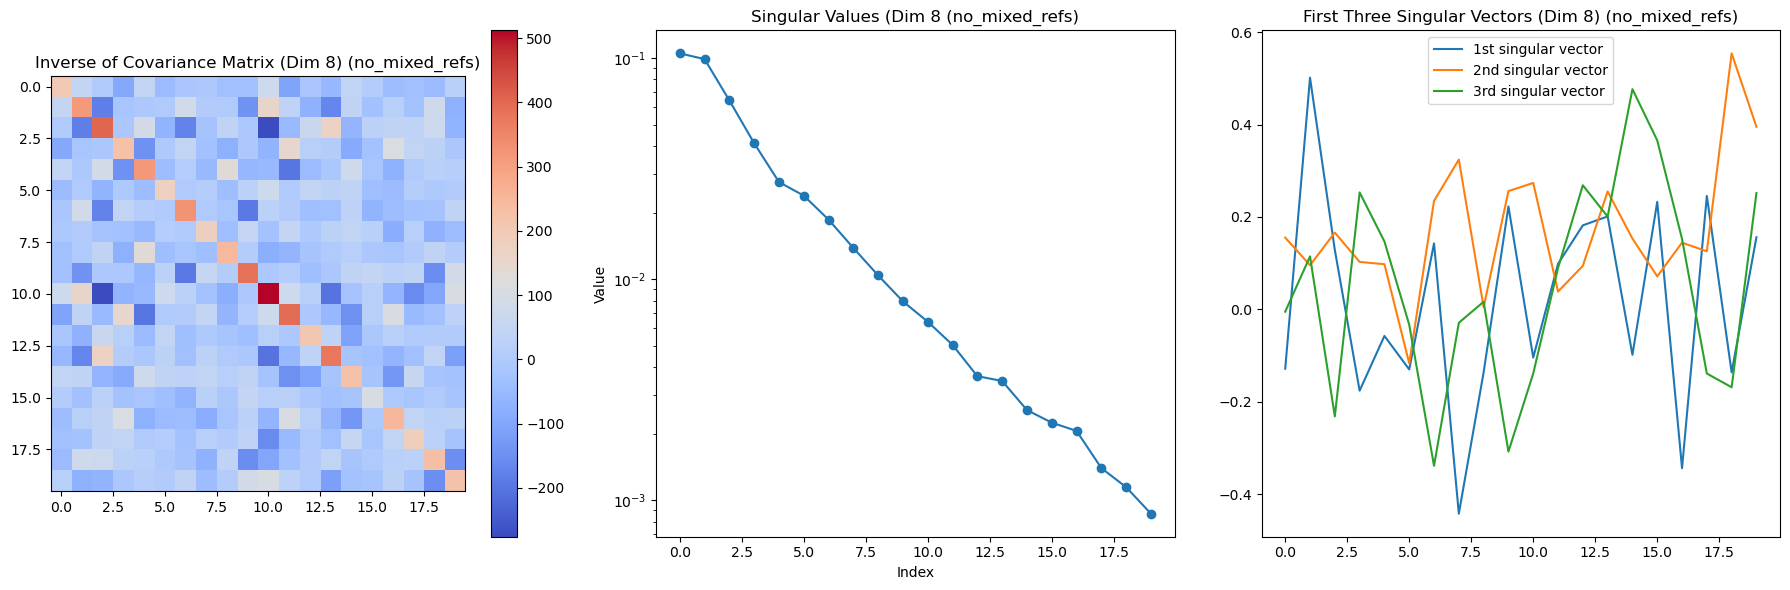

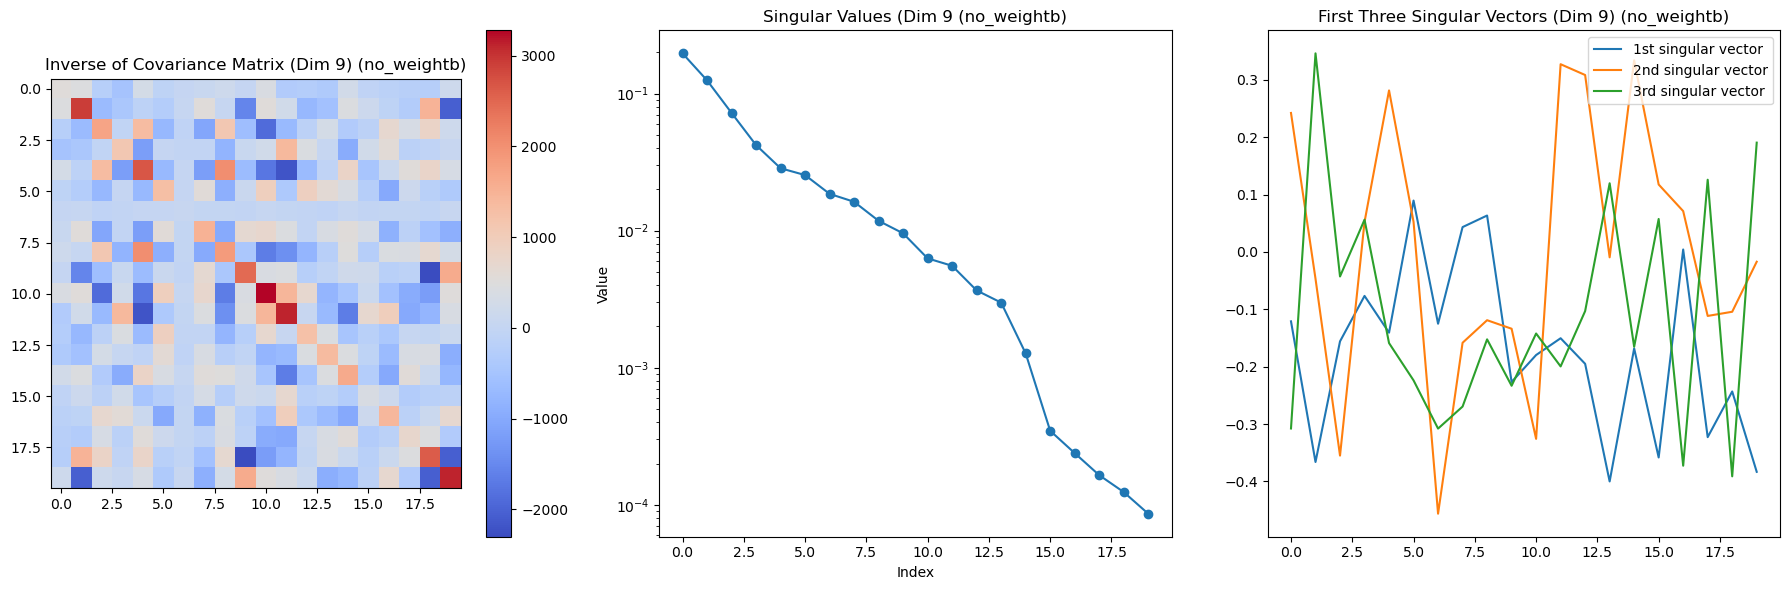

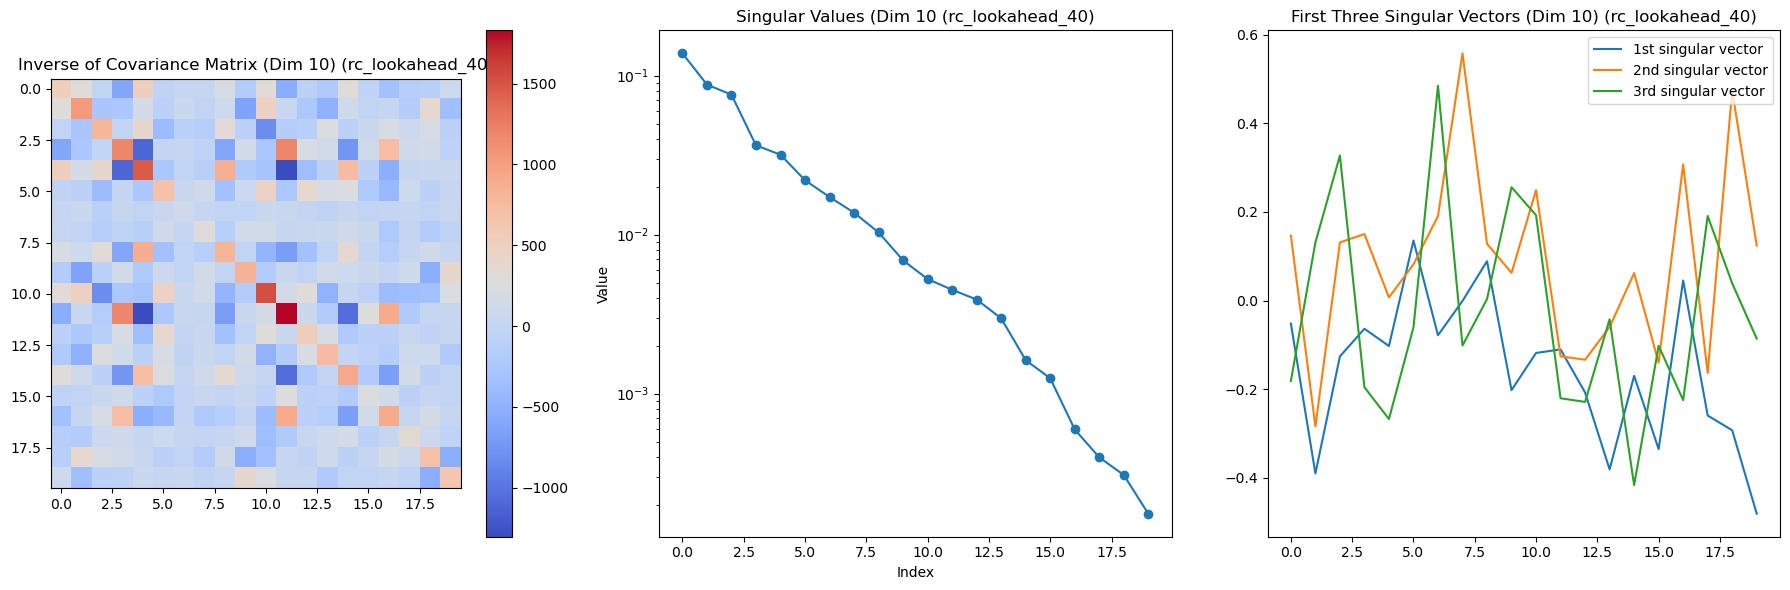

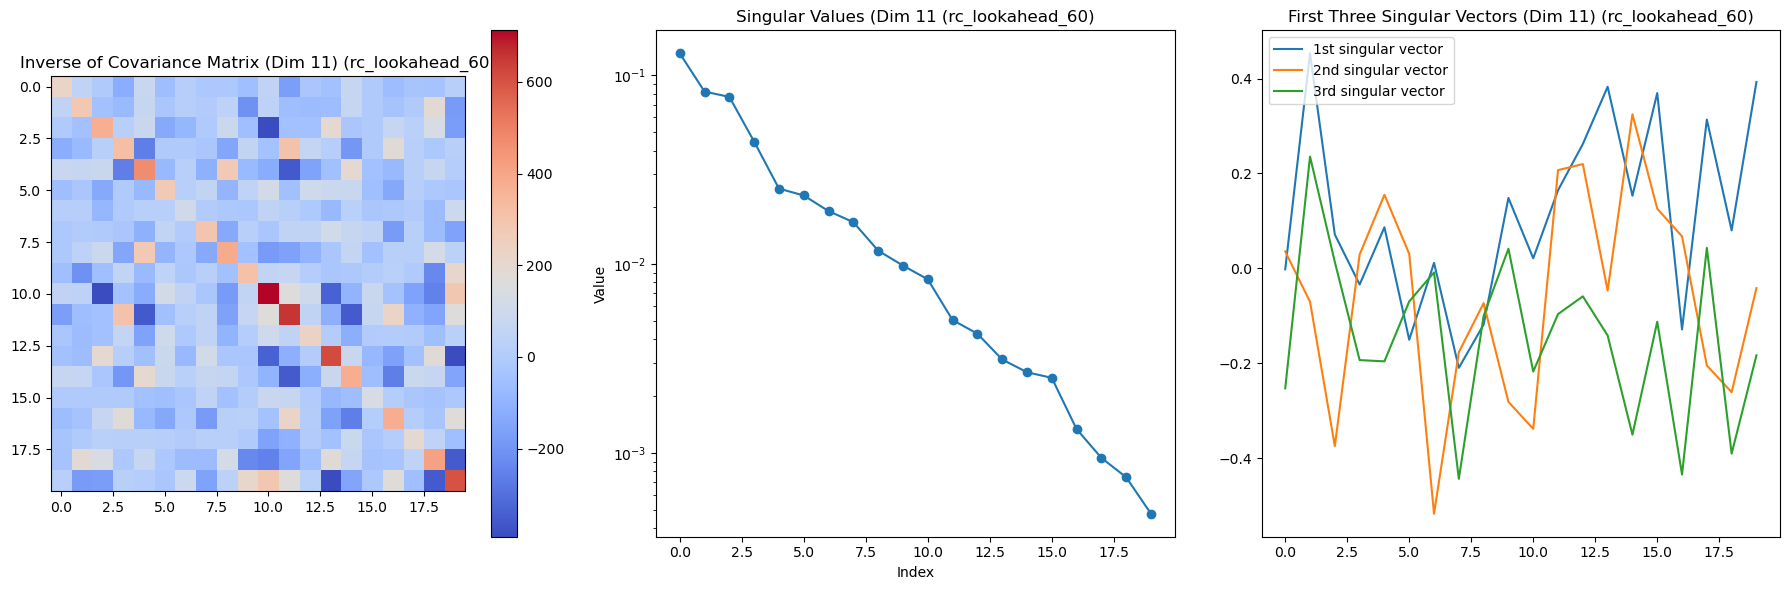

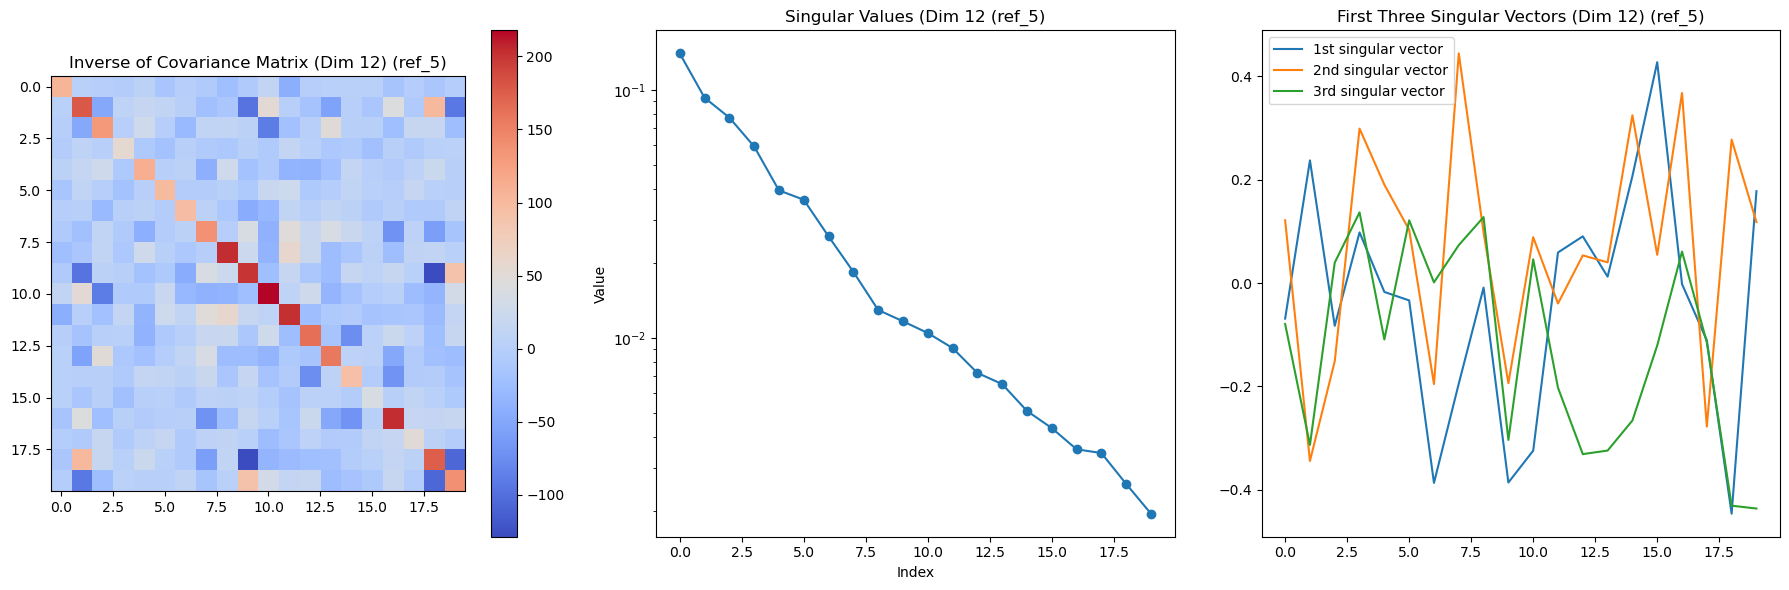

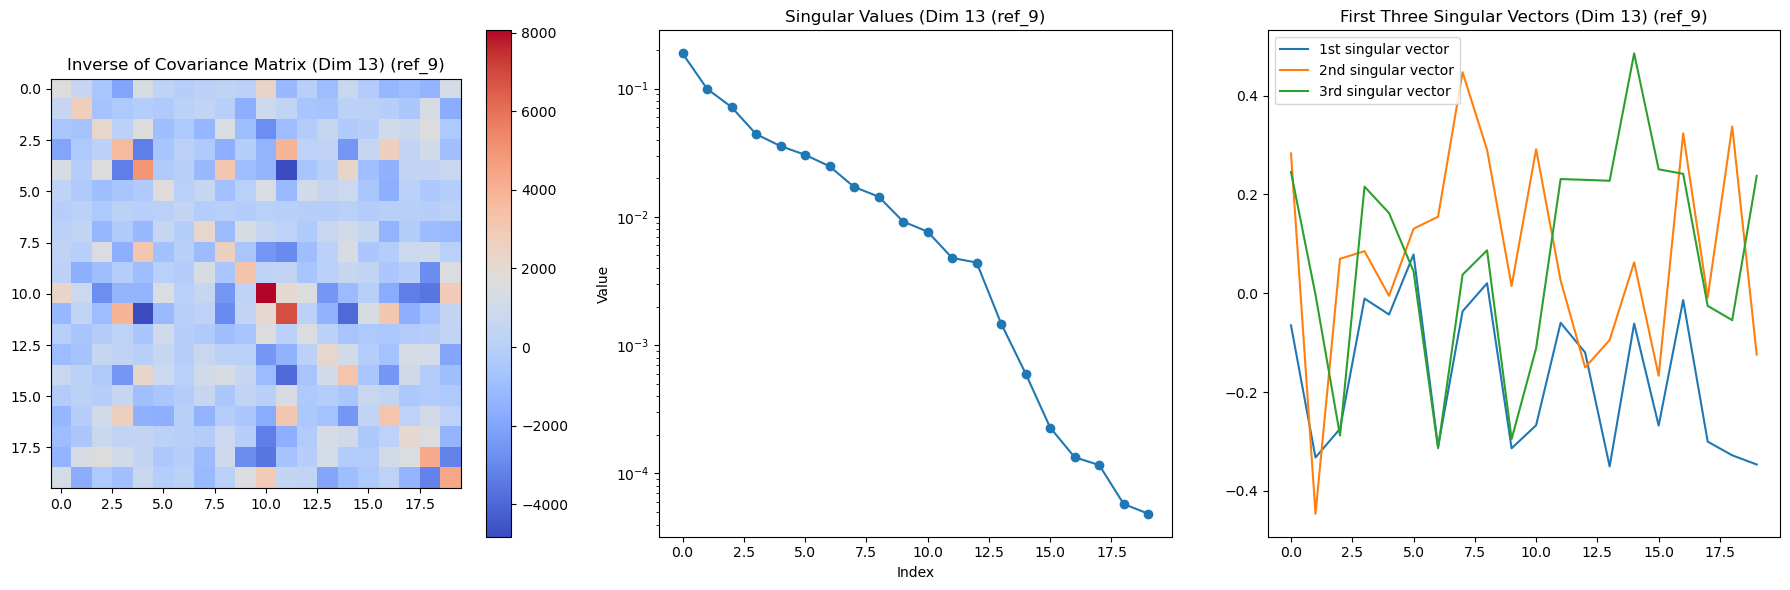

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# For each dimension, calculate and plot the inverse covariance matrix and the SVD components
for dim in range(num_dims):
    covariance_matrix = dimensional_model[dim]["covariance"].numpy()
    
    # Inverse of the covariance matrix
    inv_cov_matrix = np.linalg.inv(covariance_matrix)
    
    # Compute the SVD
    U, S, Vt = np.linalg.svd(covariance_matrix)

    # Prepare the figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot the inverse covariance matrix
    im_inv = axs[0].imshow(inv_cov_matrix, cmap='coolwarm', interpolation='nearest')
    fig.colorbar(im_inv, ax=axs[0])
    axs[0].set_title(f'Inverse of Covariance Matrix (Dim {dim}) ({feature_names[dim]})')
    
    # Plot the singular values
    axs[1].semilogy(S, 'o-')
    axs[1].set_title(f'Singular Values (Dim {dim} ({feature_names[dim]})')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Value')
    
    # Plot the first two singular vectors (U matrix)
    axs[2].plot(U[:, 0], label='1st singular vector')
    axs[2].plot(U[:, 1], label='2nd singular vector')
    axs[2].plot(U[:, 2], label='3rd singular vector')
    axs[2].set_title(f'First Three Singular Vectors (Dim {dim}) ({feature_names[dim]})')
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()


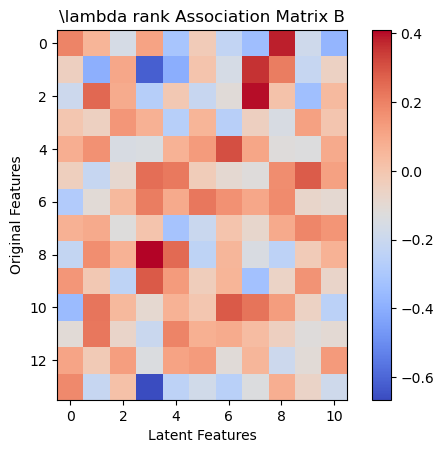

In [111]:
plt.imshow(B.numpy(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('\lambda rank Association Matrix B')
plt.xlabel('Latent Features')
plt.ylabel('Original Features')
plt.show()

## linear L1 regularizer vs. non-linear inverse lengthscales

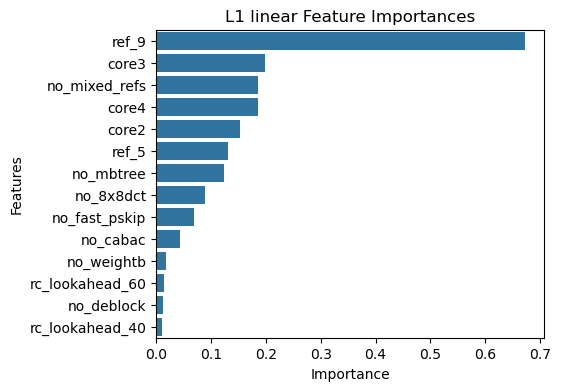

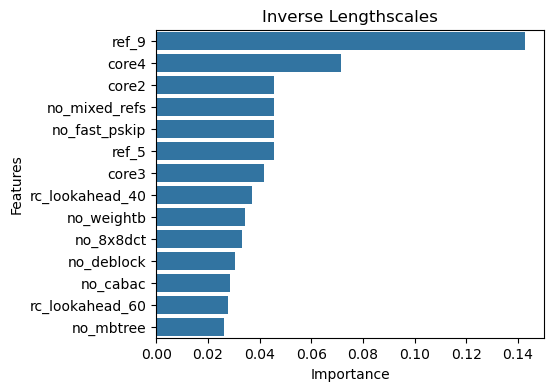

In [132]:
import plotly.graph_objects as go

# Example data: length scales for each feature
length_scales = model.median_lengthscale.detach()
features = feature_names

lengthscale_sorted = list(torch.sort(length_scales)[0])
lengthscale_argsorted = list(torch.argsort(length_scales))
feature_names = list(feature_names)
sorted_lengthscale = [1.0 / int(lengthscale_sorted[i].numpy()) for i in range(len(model.median_lengthscale))]
sorted_lengthscalefeatures = [feature_names[lengthscale_argsorted[i]] for i in range(len(model.median_lengthscale))]
fig = go.Figure(data=[
    go.Bar(x=sorted_features, y=sorted_lengthscale, marker_color='blue')
])

# Enhance interactivity
fig.update_layout(title_text='Interactive Visualization of Length Scales',
                  xaxis_title='Feature',
                  yaxis_title='Length Scale',
                  hovermode='closest')

#fig.show()

# Create a bar plot
plt.figure(figsize=(5, 4))
sns.barplot(x=sorted_features.values, y=sorted_features.index)
plt.title('L1 linear Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


# Create a bar plot
plt.figure(figsize=(5, 4))
sns.barplot(x=sorted_lengthscale, y=sorted_lengthscalefeatures)
plt.title('Inverse Lengthscales')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Make a GRID search over groups of boolean masks 